In [1]:
import os
import sys
#
import tensorflow as tf
# limit gpu mem
#gpus = tf.config.list_physical_devices('GPU')
#tf.config.set_logical_device_configuration(gpus[0],[tf.config.LogicalDeviceConfiguration(memory_limit=3700)])
#
gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, AveragePooling2D, BatchNormalization, Conv2D, Conv2DTranspose,
    Dense, Dropout, Flatten, Input, LeakyReLU, ReLU, UpSampling2D)
from tensorflow.keras.models import Sequential, Model
from time import time

import numpy as np
import cv2
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras import Input
#from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import Conv2D
#
from matplotlib import pyplot
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import load_img,save_img
#from keras.utils.vis_utils import plot_model
from copy import deepcopy

from skimage.color import rgb2lab, lab2rgb, rgb2hsv, hsv2rgb
from PIL import Image

image_shape=(480,480,1)    
convstride=np.array([[[3,3],[1,1]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])
convstride_dis=np.array([[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]],[[3,3],[2,2]]])

2023-09-26 09:52:31.071924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 09:52:31.906458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-26 09:52:32.646743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-26 09:52:32.696554: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

1 Physical GPUs, 1 Logical GPUs


In [2]:
# conversion lab & rgb
def lab_to_rgb(img_lab):
    img_lab = img_lab.numpy()
    L = (img_lab[:,:,:,0] + 1.) * 50. 
    L = L[..., np.newaxis]
    ab = img_lab[:,:,:,1:]  * 110
    img_lab = np.concatenate((L,ab),axis=3)
    #
    img = lab2rgb(img_lab).astype("float32")
    img = (img * 255).astype(np.uint8)
    return img

def rgb_to_lab(img):
    img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b    # float16 to optimize ?
    # Between -1 and 1
    L  = img_lab[:,:,0]  / 50. - 1. 
    ab = img_lab[:,:,1:]  / 110. # Between -1 and 1 
    return L, ab

**MODEL**

In [3]:
# define an encoder block
def define_encoder_block(layer_in,name, n_filters,kernel=(3,3),strides=(2,2), batchnorm=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add downsampling layer
        g = Conv2D(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # conditionally add batch normalization
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        # leaky relu activation
        g = LeakyReLU(alpha=0.2)(g)
        return g

# define a decoder block
def decoder_block(layer_in, skip_in,name, n_filters,kernel=(3,3),strides=(2,2), dropout=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add upsampling layer
        g = Conv2DTranspose(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # add batch normalization
        g = BatchNormalization()(g, training=True)
        # conditionally add dropout
        if dropout:
            g = Dropout(0.3)(g, training=True)
        # merge with skip connection
        g = Concatenate()([g, skip_in])
        # relu activation
        g = Activation('relu')(g)
        return g

# define the standalone generator model
def define_generator(image_shape):   # input L : 480x640x1, output ab : 480x640x1 
        convstrideg=convstride.copy()
        print(convstrideg.shape)
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e0 = define_encoder_block(in_image,"encoder_block_0", 32, kernel=conv,strides=stride) # 64
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e1 = define_encoder_block(e0,"encoder_block_1", 64, kernel=conv,strides=stride) # 64
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e2 = define_encoder_block(e1,"encoder_block_2", 128,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e3 = define_encoder_block(e2,"encoder_block_3", 256,kernel=conv,strides=stride) # 16
        
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        e4 = define_encoder_block(e3,"encoder_block_4", 512,kernel=conv,strides=stride) # 16
        # bottleneck, no batch norm and relu
        (conv,stride),convstrideg=convstrideg[0,:,:],convstrideg[1:,:,:]
        b = Conv2D(512, conv,strides=stride, padding='same', kernel_initializer=init,name="bottleneck_conv2d")(e4)
        b = Activation('relu')(b)
        # decoder model
        convstrideg=convstride.copy()
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d4 = decoder_block(b, e4,"decoder_block_4", 512,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d5 = decoder_block(d4, e3,"decoder_block_3",256,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d6 = decoder_block(d5, e2,"decoder_block_2", 128,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d7 = decoder_block(d6, e1,"decoder_block_1", 64,kernel=conv,strides=stride, dropout=False)
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        d8 = decoder_block(d7, e0,"decoder_block_0", 32,kernel=conv,strides=stride, dropout=False)
        # output
        (conv,stride),convstrideg=convstrideg[-1,:,:],convstrideg[:-1,:,:]
        g = Conv2DTranspose(2, conv,strides=stride, padding='same',kernel_initializer=init)(d8)    
        out_image = Activation('tanh')(g)
        
        # define model
        model = Model(in_image, out_image)
        model.summary()
        return model


# define the discriminator model
def define_discriminator(image_shape):    # input concatenate(L,ab) : 480x640x3, output : 1,0
        convstrided=convstride_dis.copy()
        print(convstrided.shape)
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_src_image = Input(shape=image_shape)
        # C64
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(32, conv, strides=stride, padding='same', kernel_initializer=init)(in_src_image)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(64, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(128, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(256, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # last output layer
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(512, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        (conv,stride),convstrided=convstrided[0,:,:],convstrided[1:,:,:]
        d = Conv2D(1, conv, strides=stride, padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model(in_src_image, patch_out)
        model.summary()
        return model

**LOSS**

In [4]:
LAMBDA = 100 #100
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)
    # mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    # 
    total_gen_loss = gan_loss + (LAMBDA*l1_loss)
    return total_gen_loss, gan_loss, l1_loss



In [5]:
generator = define_generator(image_shape=(512,512,3))
discriminator = define_discriminator(image_shape=(512,512,3))

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)    #2e-4
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)  #2e-4

(6, 2, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 512, 512, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 32)         128       ['encoder_block_0[0][0]']     
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 512, 512, 32)         0         ['batch_normaliz

                                                                                                  
 batch_normalization_8 (Bat  (None, 256, 256, 64)         256       ['decoder_block_1[0][0]']     
 chNormalization)                                                                                 
                                                                                                  
 concatenate_3 (Concatenate  (None, 256, 256, 128)        0         ['batch_normalization_8[0][0]'
 )                                                                  , 'leaky_re_lu_1[0][0]']      
                                                                                                  
 activation_4 (Activation)   (None, 256, 256, 128)        0         ['concatenate_3[0][0]']       
                                                                                                  
 decoder_block_0 (Conv2DTra  (None, 512, 512, 32)         36896     ['activation_4[0][0]']        
 nspose)  

/home/anton/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256, 256, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 batch_normalization_10 (Ba  (None, 128, 128, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 

In [6]:
# plot real source images
def summarize_performance(step,generator,n_samples, L_src, ab_src, ab_old):
    L_src = L_src[0:1]
    ab_src = ab_src[0:1]
    ab_old = ab_old[0:1]
    # Fake
    ab_fake = generator(tf.keras.layers.concatenate([L_src, ab_old]), training=False)
    X_fake = tf.keras.layers.concatenate([L_src, ab_fake])
    X_fake_rgb=lab_to_rgb(X_fake)
    # Real (new)
    X_real = tf.keras.layers.concatenate([L_src.numpy(), ab_src.numpy()])
    X_real_rgb=lab_to_rgb(X_real)
    # old
    X_old = tf.keras.layers.concatenate([L_src.numpy(), ab_old.numpy()])
    X_old_rgb=lab_to_rgb(X_old)

    pyplot.subplot(1, 3, 1)
    pyplot.axis('off')       
    pyplot.imshow(X_fake_rgb[0])
    
    pyplot.subplot(1, 3, 2)
    pyplot.axis('off')       
    pyplot.imshow(X_real_rgb[0]) 
    
    pyplot.subplot(1, 3, 3)
    pyplot.axis('off')       
    pyplot.imshow(X_old_rgb[0])     

    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()

def count_colors(img):
    unique, counts = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
    x = [];y = [];z = [];c = [];s = []
    for i,col in enumerate(unique):
        x.append(col[0]);y.append(col[1]);z.append(col[2])
        c.append((col[0] / 255, col[1] / 255, col[2] / 255))
        s.append(counts[i]/10)
    return len(counts)
    
def test_loss_avg(generator,path):
    CNT=[]
    path_image=os.path.join(path,'test_new')
    path_old=os.path.join(path,'test_old')
    Loss_avg = list()
    L1_avg = list()

    IMAGE=os.listdir(path_image)
    OLD=os.listdir(path_old)
    IMAGE.sort()
    OLD.sort()
    
    for file_img, file_old in zip(IMAGE,OLD):
        print(file_img,file_old)
        new_im = os.path.join(path_image,file_img)
        old_im = os.path.join(path_old,file_old)
        X1=[]
        X2=[]
        X3=[]
        # now read the input image files (difference from the code it is derived from that preloads all images)
        pixels = Image.open(new_im).convert("RGB")
        L_src, ab_src=rgb_to_lab(pixels)
        #
        pixels_old = Image.open(old_im).convert("RGB")
        L_bin, ab_old=rgb_to_lab(pixels_old)
        #
        X1.append(L_src)
        X2.append(ab_src)
        X3.append(ab_old)
        X1=np.array(X1)
        ab_src=np.array(X2)
        ab_old=np.array(X3)
        L_src = X1[..., np.newaxis]
        #
        ab_fake = generator(tf.keras.layers.concatenate([L_src, ab_old]), training=False)
        #
        img=tf.keras.layers.concatenate([L_src, ab_fake])
        target=tf.keras.layers.concatenate([L_src, ab_src])
        disc_on_test = discriminator(img,training=False)
        #
        test_loss, gan_loss, l1_loss=generator_loss(disc_on_test, img, target)
        Loss_avg.append(test_loss)
        L1_avg.append(l1_loss)
        CNT.append(count_colors(img))
        
    avg = np.mean(Loss_avg) 
    l1 = np.mean(L1_avg)
    print(np.mean(CNT))
    return avg, l1

def shuffle_and_batch(Dataset, buff_size, SEED):
    # SHUFFLE
    Dataset_S = Dataset.shuffle(buffer_size = buff_size,seed=SEED)    #10 * BATCH_SIZE   L_dataset.cardinality()
    # Batch
    Dataset_B = Dataset_S.batch(BATCH_SIZE)
    return(Dataset_B)

def change_Bright(L,ab,B):      
    L_n = (L[0:1] + 1.) * 50. 
    ab_n = ab[0:1]  * 110
    img_lab = tf.keras.layers.concatenate([L_n, ab_n]).numpy()
    #
    #print(img_lab.shape)
    img = lab2rgb(img_lab).astype("float32")
    img = (img * 255).astype(np.uint8)
    img = rgb2hsv(img)
    img[:,:,:,2] = np.clip(img[:,:,:,2]*B,0,255)
    L_b, ab_b = rgb_to_lab(hsv2rgb(img[0]))
    L_b = L_b[np.newaxis ,..., np.newaxis]
    ab_b = ab_b[np.newaxis ,...]
    #print(L_b.shape, ab_b.shape, tf.shape(L[1:]))
    L_final = tf.keras.layers.concatenate([L_b, L[1:]],axis=0)
    #print(tf.shape(L_final))
    ab_final = tf.keras.layers.concatenate([ab_b, ab[1:]],axis=0)
    return L_final, ab_final


In [7]:
@tf.function
def train_step(generator,discriminator,L, ab, ab_old, batch):    #input image : L (480,640,1)  && target : Lab image (480,640,2)
    GL=DL= tf.constant(0.)      
    # for each image of the batch
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        for i in range(batch):  # tf.shape(L)[0].numpy()
            L_ch = L[i:i+1]
            ab_ch = ab[i:i+1]
            ab_o_ch = ab_old[i:i+1]
            #
            gen_output = generator(tf.keras.layers.concatenate([L_ch, ab_o_ch]), training=True)

            disc_real_output = discriminator(tf.keras.layers.concatenate([L_ch, ab_ch]), training=True)
            disc_generated_output = discriminator(tf.keras.layers.concatenate([L_ch, gen_output]) , training=True)

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
                disc_generated_output, gen_output, ab_ch)
            disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

            DL=tf.add(DL,disc_loss)
            GL=tf.add(GL,gen_total_loss)
            
            #print("ok3")

        # mean of batch loss
        DL = tf.math.divide(DL,batch)
        GL = tf.math.divide(GL,batch)
        # Update at the end of batch
        generator_gradients = gen_tape.gradient(GL,
                                                generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(DL,
                                                     discriminator.trainable_variables)
        generator_optimizer.apply_gradients(zip(generator_gradients,
                                              generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                  discriminator.trainable_variables))
        #print("ok4")

    return GL, DL


# train pix2pix models
def train(d_model, g_model, dataset, batch=4):
    # determine the output square shape of the discriminator
    n_patch1 = d_model.output_shape[1]
    n_patch2 = d_model.output_shape[2]
    # calculate the number of batches per training epoch
    #
    GLoss = []
    DLoss = []
    i=0
    # manually enumerate batch
    for Data in dataset:
        # Split
        L= Data[:,:,:,0:1]
        ab= Data[:,:,:,1:3]
        ab_old= Data[:,:,:,3:5]
        # BRIGHT +/-
        bright = np.clip(np.random.normal(0.8,0.2),0.7,1.2)    
        L_b, ab_b = change_Bright(L,ab,bright)
        L_bin, ab_old_b = change_Bright(L,ab_old,bright)
        # train step, update loss, gradient
        gen_loss, disc_loss = train_step(g_model,d_model,L_b, ab_b, ab_old_b,batch)   
        #
        print("step "+str(i)+" gen_loss : "+str(gen_loss.numpy())+" disc_loss : "+str(disc_loss.numpy())+" Bright coef : "+str(bright))
        GLoss.append(gen_loss.numpy())
        DLoss.append(disc_loss.numpy())
        # summarize model performance every 200 steps
        if (i % 40 == 0) and (i !=0):
            summarize_performance(i,generator,1, L_b, ab_b, ab_old_b)
        i+=1
    return(DLoss,GLoss,d_model, g_model)


In [8]:
import tensorflow.python.ops.numpy_ops.np_config as np_config
np_config.enable_numpy_behavior()

Learning Rate G : 0.00015 Learning Rate D : 0.00015
Seed :  7233

Start of epoch 1


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911
2023-09-26 09:52:45.198514: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuD

step 0 gen_loss : 22.460941 disc_loss : 1.7314233 Bright coef : 1.0479883963756345
step 1 gen_loss : 17.573847 disc_loss : 1.6931056 Bright coef : 0.7719400664380718
step 2 gen_loss : 17.783756 disc_loss : 1.8036318 Bright coef : 1.1942640349889184
step 3 gen_loss : 15.137173 disc_loss : 1.7664871 Bright coef : 0.7
step 4 gen_loss : 15.411559 disc_loss : 1.6517055 Bright coef : 0.7
step 5 gen_loss : 15.885024 disc_loss : 1.5917962 Bright coef : 0.807863908819118
step 6 gen_loss : 15.111662 disc_loss : 1.4543993 Bright coef : 0.9818797354109949
step 7 gen_loss : 9.742168 disc_loss : 1.5670955 Bright coef : 0.7566464250426345
step 8 gen_loss : 10.074042 disc_loss : 1.8514686 Bright coef : 0.876032417979694
step 9 gen_loss : 12.468636 disc_loss : 1.580342 Bright coef : 0.9698841912762135
step 10 gen_loss : 9.910093 disc_loss : 2.4478183 Bright coef : 0.7
step 11 gen_loss : 9.957001 disc_loss : 1.6277294 Bright coef : 0.9016562602064786
step 12 gen_loss : 6.440296 disc_loss : 1.8450396 Bri

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


step 41 gen_loss : 7.829038 disc_loss : 1.4247437 Bright coef : 0.7170868074418391
step 42 gen_loss : 5.7289443 disc_loss : 1.4486873 Bright coef : 0.7
step 43 gen_loss : 6.6526155 disc_loss : 1.4204266 Bright coef : 0.9664614188454032
step 44 gen_loss : 4.1964073 disc_loss : 1.4400053 Bright coef : 0.7
step 45 gen_loss : 4.6814327 disc_loss : 1.4595914 Bright coef : 0.7103143777116648
step 46 gen_loss : 7.0303183 disc_loss : 1.4693222 Bright coef : 0.7007646230099981
step 47 gen_loss : 8.854534 disc_loss : 1.4451487 Bright coef : 0.8491613741053397
step 48 gen_loss : 7.9582405 disc_loss : 1.4898863 Bright coef : 1.2
step 49 gen_loss : 7.085018 disc_loss : 1.4568818 Bright coef : 1.1811111132779657
step 50 gen_loss : 7.352548 disc_loss : 1.4606991 Bright coef : 0.7962362584837251
step 51 gen_loss : 5.080077 disc_loss : 1.4730412 Bright coef : 0.810102752807804
step 52 gen_loss : 7.8435354 disc_loss : 1.434647 Bright coef : 1.2
step 53 gen_loss : 5.100383 disc_loss : 1.4347316 Bright co

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 31 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


step 121 gen_loss : 4.753782 disc_loss : 1.4177501 Bright coef : 0.7
step 122 gen_loss : 5.4490366 disc_loss : 1.3984824 Bright coef : 1.0415153732666869
step 123 gen_loss : 4.8399367 disc_loss : 1.3296113 Bright coef : 0.7
step 124 gen_loss : 5.5648484 disc_loss : 1.309459 Bright coef : 0.9575631491394996
step 125 gen_loss : 8.301076 disc_loss : 1.3548511 Bright coef : 0.8851297669101904
step 126 gen_loss : 7.567544 disc_loss : 1.3204374 Bright coef : 0.9746939277170975
step 127 gen_loss : 5.5468335 disc_loss : 1.3796561 Bright coef : 1.0056848367726021
step 128 gen_loss : 6.2208033 disc_loss : 1.5103803 Bright coef : 0.8938252932301379
step 129 gen_loss : 3.6717737 disc_loss : 1.3586062 Bright coef : 0.7
step 130 gen_loss : 5.8845387 disc_loss : 1.4275467 Bright coef : 0.7
step 131 gen_loss : 5.2581477 disc_loss : 1.4018788 Bright coef : 0.9594615728849742
step 132 gen_loss : 5.6301584 disc_loss : 1.3832266 Bright coef : 0.701254940051524
step 133 gen_loss : 8.4951105 disc_loss : 1.3

step 225 gen_loss : 3.3096828 disc_loss : 1.391035 Bright coef : 1.055124725662223
step 226 gen_loss : 3.2679162 disc_loss : 1.3639171 Bright coef : 0.794323460276066
step 227 gen_loss : 7.199026 disc_loss : 1.3427434 Bright coef : 1.041318434843002
step 228 gen_loss : 2.823778 disc_loss : 1.3693836 Bright coef : 0.7
step 229 gen_loss : 4.360098 disc_loss : 1.3843172 Bright coef : 0.8154649234381068
step 230 gen_loss : 6.8146253 disc_loss : 1.3611431 Bright coef : 0.8765811119926008
step 231 gen_loss : 4.908677 disc_loss : 1.3671982 Bright coef : 0.7
step 232 gen_loss : 3.1401494 disc_loss : 1.3602278 Bright coef : 0.7
step 233 gen_loss : 3.1744816 disc_loss : 1.3785493 Bright coef : 0.8894836787097196
step 234 gen_loss : 4.9991293 disc_loss : 1.4001242 Bright coef : 0.7497038200169989
step 235 gen_loss : 9.179624 disc_loss : 1.3624225 Bright coef : 1.0301438351287564
step 236 gen_loss : 6.162368 disc_loss : 1.3711938 Bright coef : 0.7325698856525744
step 237 gen_loss : 6.699059 disc_l

step 328 gen_loss : 5.2524242 disc_loss : 1.4268411 Bright coef : 0.7254841317352604
step 329 gen_loss : 4.247876 disc_loss : 1.4279897 Bright coef : 0.7115602647744873
step 330 gen_loss : 3.3111253 disc_loss : 1.3896265 Bright coef : 0.7286942147716317
step 331 gen_loss : 3.3621814 disc_loss : 1.4138641 Bright coef : 0.7
step 332 gen_loss : 12.208827 disc_loss : 1.3768792 Bright coef : 0.991674478287864
step 333 gen_loss : 4.1670313 disc_loss : 1.405445 Bright coef : 0.7
step 334 gen_loss : 8.113761 disc_loss : 1.3902309 Bright coef : 0.8823397898170406
step 335 gen_loss : 3.899929 disc_loss : 1.3956628 Bright coef : 1.1256383529264424
step 336 gen_loss : 6.210532 disc_loss : 1.3878629 Bright coef : 0.9313109386691463
step 337 gen_loss : 5.4376993 disc_loss : 1.38489 Bright coef : 0.840440162766186
step 338 gen_loss : 5.4701157 disc_loss : 1.3349528 Bright coef : 0.7
step 339 gen_loss : 4.9060855 disc_loss : 1.3969669 Bright coef : 0.7
step 340 gen_loss : 4.236935 disc_loss : 1.406963

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 17 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


step 401 gen_loss : 6.025313 disc_loss : 1.3905557 Bright coef : 0.7400502319760356
step 402 gen_loss : 7.786104 disc_loss : 1.3620689 Bright coef : 0.7529779529579863
step 403 gen_loss : 4.7951655 disc_loss : 1.3994904 Bright coef : 0.7
step 404 gen_loss : 8.4968405 disc_loss : 1.3876964 Bright coef : 0.8754715001692914
step 405 gen_loss : 7.630965 disc_loss : 1.3248317 Bright coef : 1.1752264378691986
step 406 gen_loss : 4.5357685 disc_loss : 1.4215453 Bright coef : 0.9418472127445328
step 407 gen_loss : 4.9076257 disc_loss : 1.378972 Bright coef : 0.8497912263161391
step 408 gen_loss : 4.8792496 disc_loss : 1.425355 Bright coef : 0.7
step 409 gen_loss : 4.427005 disc_loss : 1.4079278 Bright coef : 0.7
step 410 gen_loss : 3.5410922 disc_loss : 1.3927299 Bright coef : 0.7
step 411 gen_loss : 3.293681 disc_loss : 1.407474 Bright coef : 0.7
step 412 gen_loss : 2.6411643 disc_loss : 1.3872275 Bright coef : 0.7
step 413 gen_loss : 4.1623926 disc_loss : 1.3699076 Bright coef : 0.7449468777

step 505 gen_loss : 4.9725504 disc_loss : 1.3887881 Bright coef : 0.9630868823218535
step 506 gen_loss : 5.103034 disc_loss : 1.3725858 Bright coef : 0.7294486766062311
step 507 gen_loss : 4.0296783 disc_loss : 1.360295 Bright coef : 0.9276186732267946
step 508 gen_loss : 4.4247985 disc_loss : 1.3763447 Bright coef : 1.0924423712989393
step 509 gen_loss : 4.605709 disc_loss : 1.3702621 Bright coef : 0.7
step 510 gen_loss : 4.4644127 disc_loss : 1.4053857 Bright coef : 0.7
step 511 gen_loss : 6.326307 disc_loss : 1.3517901 Bright coef : 0.7236041622224535
step 512 gen_loss : 4.6933684 disc_loss : 1.3893633 Bright coef : 0.7
step 513 gen_loss : 3.7201056 disc_loss : 1.3772906 Bright coef : 0.7659882087199514
step 514 gen_loss : 13.916035 disc_loss : 1.3440375 Bright coef : 1.0370652759624222
step 515 gen_loss : 5.1942596 disc_loss : 1.3825029 Bright coef : 0.8335200568026931
step 516 gen_loss : 4.0688267 disc_loss : 1.388599 Bright coef : 0.8924887620895907
step 517 gen_loss : 7.315329 d

step 608 gen_loss : 4.564531 disc_loss : 1.3858049 Bright coef : 0.8092580842040406
step 609 gen_loss : 3.93891 disc_loss : 1.3816895 Bright coef : 0.7437570679367345
step 610 gen_loss : 4.3439198 disc_loss : 1.3879004 Bright coef : 0.7237030206047903
step 611 gen_loss : 7.279413 disc_loss : 1.3846885 Bright coef : 0.783745136767484
step 612 gen_loss : 4.84974 disc_loss : 1.4172208 Bright coef : 0.7
step 613 gen_loss : 3.2515965 disc_loss : 1.3867201 Bright coef : 0.8022262964256824
step 614 gen_loss : 7.1059265 disc_loss : 1.4292204 Bright coef : 1.07803867361014
step 615 gen_loss : 5.289939 disc_loss : 1.3848903 Bright coef : 0.7
step 616 gen_loss : 12.501344 disc_loss : 1.3273561 Bright coef : 1.0947494935520445
step 617 gen_loss : 5.3776517 disc_loss : 1.3490176 Bright coef : 0.9030538486833859
step 618 gen_loss : 2.8277857 disc_loss : 1.4126561 Bright coef : 0.7
step 619 gen_loss : 4.634194 disc_loss : 1.4081314 Bright coef : 0.8629951366092566
step 620 gen_loss : 4.742833 disc_lo

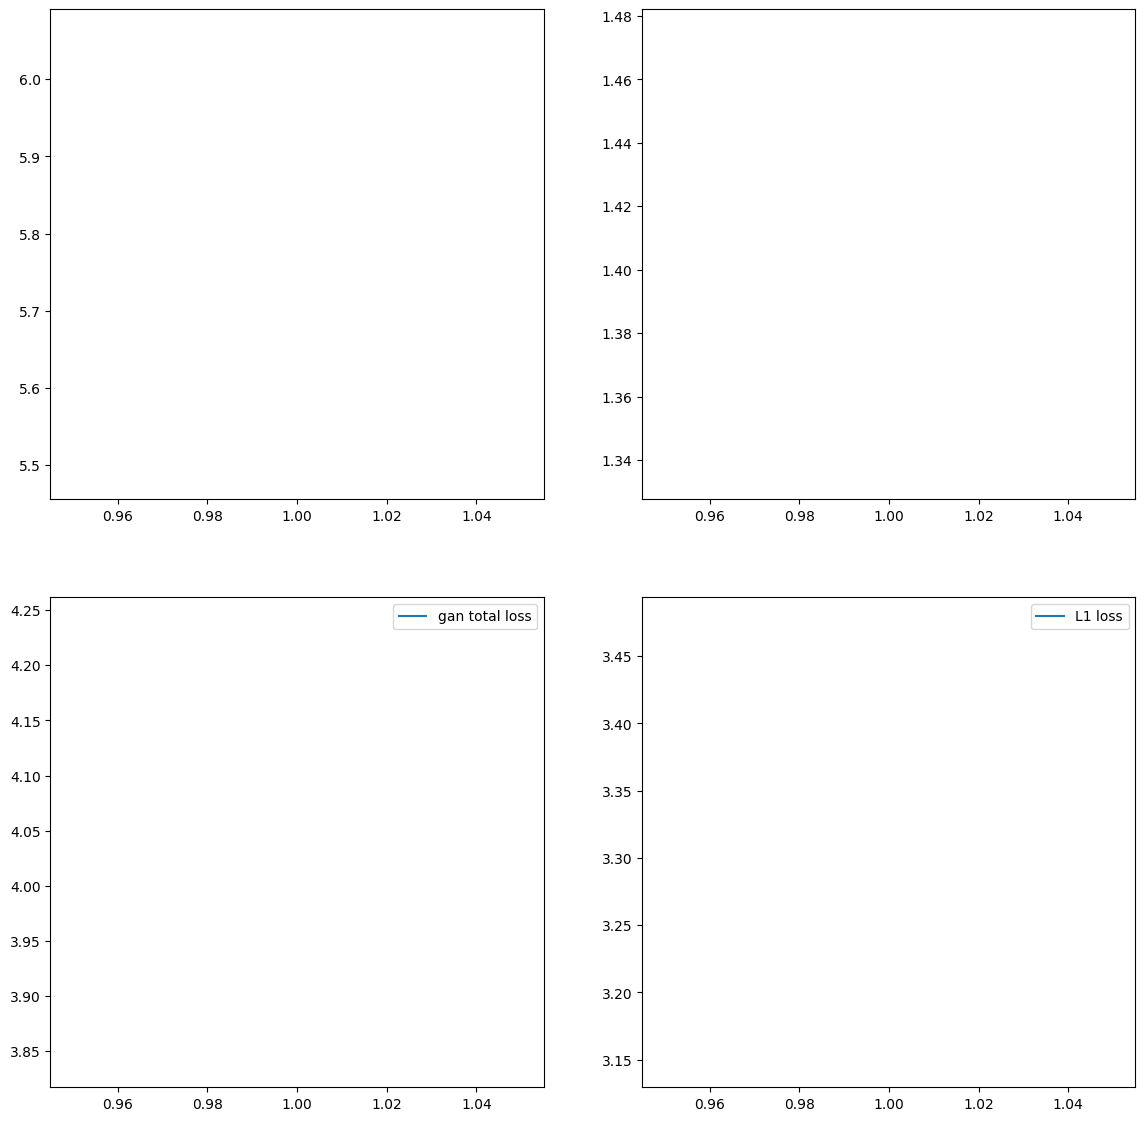

Seed :  7729

Start of epoch 2


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 4.716564 disc_loss : 1.4051337 Bright coef : 0.8782115849165429
step 1 gen_loss : 3.1638825 disc_loss : 1.4467126 Bright coef : 0.7
step 2 gen_loss : 4.0552044 disc_loss : 1.4009051 Bright coef : 0.7
step 3 gen_loss : 2.9217784 disc_loss : 1.3874515 Bright coef : 0.7509669512479601
step 4 gen_loss : 3.2244396 disc_loss : 1.3670182 Bright coef : 0.824884816944914
step 5 gen_loss : 4.973625 disc_loss : 1.379725 Bright coef : 1.0833046041456567
step 6 gen_loss : 4.4448414 disc_loss : 1.3749093 Bright coef : 0.8552498213615416
step 7 gen_loss : 3.4356422 disc_loss : 1.3830032 Bright coef : 1.166151173447658
step 8 gen_loss : 2.6610136 disc_loss : 1.3939598 Bright coef : 0.7
step 9 gen_loss : 3.8177466 disc_loss : 1.3856385 Bright coef : 0.8076627307938227
step 10 gen_loss : 6.015566 disc_loss : 1.3731253 Bright coef : 1.049935548231787
step 11 gen_loss : 5.251486 disc_loss : 1.3727523 Bright coef : 0.7412433328004646
step 12 gen_loss : 3.4237957 disc_loss : 1.3706851 Brig

step 106 gen_loss : 3.707022 disc_loss : 1.404502 Bright coef : 0.8465309093001964
step 107 gen_loss : 4.6085305 disc_loss : 1.3529952 Bright coef : 0.8065931476095526
step 108 gen_loss : 7.112339 disc_loss : 1.3758974 Bright coef : 0.8793831588701584
step 109 gen_loss : 6.096548 disc_loss : 1.3369071 Bright coef : 0.7
step 110 gen_loss : 4.6034756 disc_loss : 1.3341095 Bright coef : 0.8650808336833112
step 111 gen_loss : 4.968641 disc_loss : 1.4107447 Bright coef : 0.7
step 112 gen_loss : 4.976261 disc_loss : 1.3949544 Bright coef : 1.2
step 113 gen_loss : 3.5844831 disc_loss : 1.4140822 Bright coef : 0.7
step 114 gen_loss : 3.1651511 disc_loss : 1.3941767 Bright coef : 0.9053897757118194
step 115 gen_loss : 4.1475296 disc_loss : 1.3864533 Bright coef : 0.7855521801278743
step 116 gen_loss : 5.514534 disc_loss : 1.3453909 Bright coef : 0.7
step 117 gen_loss : 3.255646 disc_loss : 1.3848786 Bright coef : 0.7
step 118 gen_loss : 4.19952 disc_loss : 1.4044964 Bright coef : 0.878191158189

step 211 gen_loss : 3.6249857 disc_loss : 1.3919775 Bright coef : 0.7
step 212 gen_loss : 5.7648764 disc_loss : 1.3853447 Bright coef : 0.9239786624345577
step 213 gen_loss : 4.732841 disc_loss : 1.3993576 Bright coef : 0.9359837914591645
step 214 gen_loss : 4.102101 disc_loss : 1.3603411 Bright coef : 0.7
step 215 gen_loss : 4.9457827 disc_loss : 1.4124151 Bright coef : 0.8019290584935426
step 216 gen_loss : 3.9061518 disc_loss : 1.4062806 Bright coef : 0.779211356882928
step 217 gen_loss : 3.6733012 disc_loss : 1.3790505 Bright coef : 0.7180553564270666
step 218 gen_loss : 4.9185348 disc_loss : 1.405191 Bright coef : 0.7
step 219 gen_loss : 4.09062 disc_loss : 1.3746284 Bright coef : 0.8374915696383102
step 220 gen_loss : 3.947678 disc_loss : 1.3625262 Bright coef : 0.7
step 221 gen_loss : 3.0650294 disc_loss : 1.3829843 Bright coef : 0.7
step 222 gen_loss : 5.4611998 disc_loss : 1.3632509 Bright coef : 0.8176303357555949
step 223 gen_loss : 3.0953772 disc_loss : 1.386157 Bright coef

step 314 gen_loss : 11.63675 disc_loss : 1.337935 Bright coef : 0.888240672180938
step 315 gen_loss : 4.2069674 disc_loss : 1.4488006 Bright coef : 0.8404245277980016
step 316 gen_loss : 5.110148 disc_loss : 1.4159311 Bright coef : 0.7
step 317 gen_loss : 3.8625898 disc_loss : 1.4051999 Bright coef : 0.7
step 318 gen_loss : 6.3648405 disc_loss : 1.3984417 Bright coef : 0.9503525983018412
step 319 gen_loss : 3.9609091 disc_loss : 1.3342142 Bright coef : 1.2
step 320 gen_loss : 3.8921504 disc_loss : 1.4066396 Bright coef : 0.7710857546771435
step 321 gen_loss : 5.2709007 disc_loss : 1.3546175 Bright coef : 0.7
step 322 gen_loss : 3.850089 disc_loss : 1.393502 Bright coef : 0.9266700382619981
step 323 gen_loss : 3.7515748 disc_loss : 1.435666 Bright coef : 0.8070174426896696
step 324 gen_loss : 6.9728475 disc_loss : 1.3349705 Bright coef : 0.7
step 325 gen_loss : 5.5633264 disc_loss : 1.3263792 Bright coef : 0.7826579321880855
step 326 gen_loss : 3.2238436 disc_loss : 1.4024172 Bright coe

step 420 gen_loss : 7.056331 disc_loss : 1.2879488 Bright coef : 1.2
step 421 gen_loss : 5.9796205 disc_loss : 1.269643 Bright coef : 1.2
step 422 gen_loss : 6.016499 disc_loss : 1.4400847 Bright coef : 0.7878895196653292
step 423 gen_loss : 3.6209598 disc_loss : 1.4215991 Bright coef : 0.7
step 424 gen_loss : 3.0924177 disc_loss : 1.4151132 Bright coef : 0.7525569757890136
step 425 gen_loss : 3.5855196 disc_loss : 1.3807561 Bright coef : 0.7478530957565171
step 426 gen_loss : 6.968615 disc_loss : 1.4015005 Bright coef : 0.9519706914660374
step 427 gen_loss : 3.0187395 disc_loss : 1.3639762 Bright coef : 0.8048986145978393
step 428 gen_loss : 4.5156555 disc_loss : 1.3401563 Bright coef : 0.7222611259301406
step 429 gen_loss : 5.4778314 disc_loss : 1.2309898 Bright coef : 0.78812362628097
step 430 gen_loss : 2.8857198 disc_loss : 1.4012058 Bright coef : 0.7985389556733246
step 431 gen_loss : 6.269322 disc_loss : 1.4102244 Bright coef : 1.0553351380982376
step 432 gen_loss : 4.9071016 di

step 524 gen_loss : 4.1871247 disc_loss : 1.4073486 Bright coef : 0.8191248024813035
step 525 gen_loss : 7.5006657 disc_loss : 1.3737782 Bright coef : 1.0769151647458006
step 526 gen_loss : 3.4596822 disc_loss : 1.4558239 Bright coef : 0.8257002271856221
step 527 gen_loss : 4.047684 disc_loss : 1.4871439 Bright coef : 0.7
step 528 gen_loss : 2.6339045 disc_loss : 1.397417 Bright coef : 0.7
step 529 gen_loss : 5.3399024 disc_loss : 1.3783644 Bright coef : 1.0250996475529273
step 530 gen_loss : 3.5288825 disc_loss : 1.3423042 Bright coef : 0.7
step 531 gen_loss : 10.964228 disc_loss : 1.2355862 Bright coef : 0.7
step 532 gen_loss : 5.2140865 disc_loss : 1.4211657 Bright coef : 0.7
step 533 gen_loss : 4.75263 disc_loss : 1.420395 Bright coef : 0.8072157412759905
step 534 gen_loss : 4.517578 disc_loss : 1.3261018 Bright coef : 1.125824649992634
step 535 gen_loss : 4.521683 disc_loss : 1.3388815 Bright coef : 0.7
step 536 gen_loss : 4.659907 disc_loss : 1.4529034 Bright coef : 0.7
step 537 

step 630 gen_loss : 10.721454 disc_loss : 1.2395327 Bright coef : 1.0778484661209284
step 631 gen_loss : 5.8725204 disc_loss : 1.5446441 Bright coef : 1.164737102190475
step 632 gen_loss : 9.195002 disc_loss : 1.4442061 Bright coef : 0.7
step 633 gen_loss : 4.8707323 disc_loss : 1.4166185 Bright coef : 1.0502516882270847
step 634 gen_loss : 4.1572037 disc_loss : 1.4160105 Bright coef : 0.7849059279755608
step 635 gen_loss : 5.2774706 disc_loss : 1.4701438 Bright coef : 0.8170427434684606
step 636 gen_loss : 4.554766 disc_loss : 1.3669255 Bright coef : 0.7
step 637 gen_loss : 3.4220004 disc_loss : 1.5063384 Bright coef : 0.9096487771393682
step 638 gen_loss : 3.791739 disc_loss : 1.3902106 Bright coef : 0.7
step 639 gen_loss : 6.6654263 disc_loss : 1.4659996 Bright coef : 0.702938244298879
d_org.jpg d_org.jpg
gearth_13_09_004_org.jpg gearth_13_09_004_org.jpg
gearth_13_09_010_org.jpg gearth_13_09_010_org.jpg
gearth_13_09_016_org.jpg gearth_13_09_016_org.jpg
gearth_13_09_022_org.jpg geart

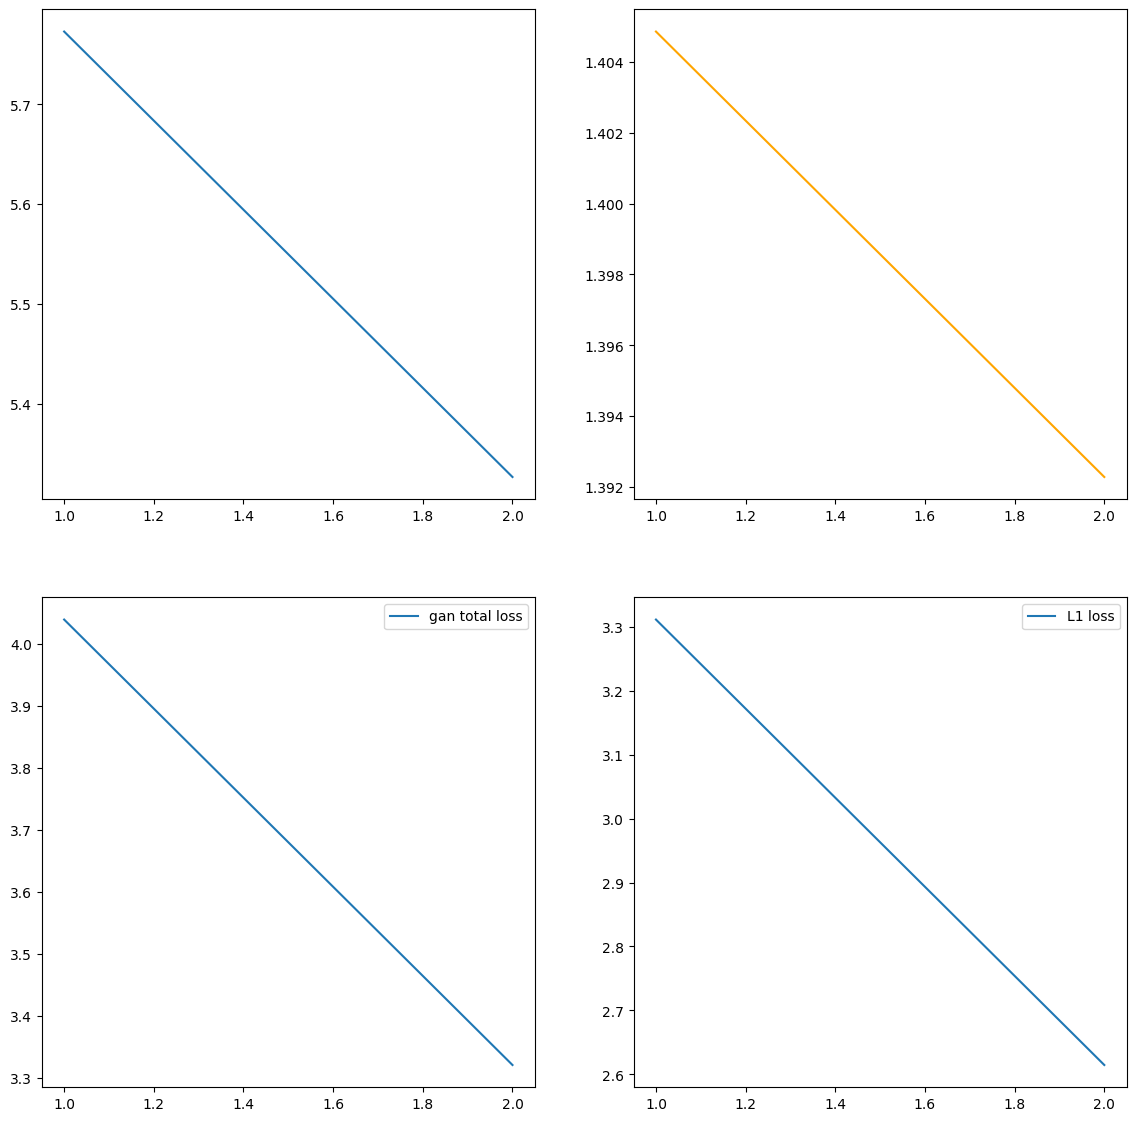

Seed :  7449

Start of epoch 3


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 2.3856814 disc_loss : 1.3764167 Bright coef : 0.7
step 1 gen_loss : 5.615939 disc_loss : 1.3182946 Bright coef : 0.7
step 2 gen_loss : 5.444764 disc_loss : 1.5127592 Bright coef : 1.2
step 3 gen_loss : 4.921712 disc_loss : 1.416739 Bright coef : 0.7
step 4 gen_loss : 4.1125097 disc_loss : 1.3641781 Bright coef : 0.756221645317193
step 5 gen_loss : 3.1223745 disc_loss : 1.3985914 Bright coef : 0.7
step 6 gen_loss : 4.5774965 disc_loss : 1.460809 Bright coef : 0.7
step 7 gen_loss : 7.802893 disc_loss : 1.3966951 Bright coef : 0.7589559630245143
step 8 gen_loss : 3.8800607 disc_loss : 1.4199426 Bright coef : 0.7
step 9 gen_loss : 4.509392 disc_loss : 1.3684366 Bright coef : 0.7
step 10 gen_loss : 8.301223 disc_loss : 1.3187052 Bright coef : 0.8025635236551956
step 11 gen_loss : 2.789517 disc_loss : 1.3813615 Bright coef : 0.8711814872416702
step 12 gen_loss : 3.3699803 disc_loss : 1.4069717 Bright coef : 0.7271885743754033
step 13 gen_loss : 4.199126 disc_loss : 1.268525

step 106 gen_loss : 6.9483438 disc_loss : 1.3730936 Bright coef : 0.7
step 107 gen_loss : 4.9265323 disc_loss : 1.289816 Bright coef : 0.7
step 108 gen_loss : 3.3136783 disc_loss : 1.445589 Bright coef : 0.7
step 109 gen_loss : 5.3699985 disc_loss : 1.2708207 Bright coef : 1.0416785782827114
step 110 gen_loss : 5.15592 disc_loss : 1.4537013 Bright coef : 0.7
step 111 gen_loss : 5.5113354 disc_loss : 1.4219627 Bright coef : 1.0756690501669404
step 112 gen_loss : 4.427593 disc_loss : 1.3748127 Bright coef : 0.7
step 113 gen_loss : 7.3112535 disc_loss : 1.3740417 Bright coef : 0.8806765304594856
step 114 gen_loss : 3.9568014 disc_loss : 1.4067193 Bright coef : 0.7
step 115 gen_loss : 3.8033466 disc_loss : 1.4021592 Bright coef : 0.78468158914878
step 116 gen_loss : 3.6385117 disc_loss : 1.4480219 Bright coef : 0.7
step 117 gen_loss : 7.4150457 disc_loss : 1.3741043 Bright coef : 0.9616215355868127
step 118 gen_loss : 4.33207 disc_loss : 1.3176696 Bright coef : 0.7
step 119 gen_loss : 3.99

step 210 gen_loss : 7.6626716 disc_loss : 1.2640533 Bright coef : 0.7
step 211 gen_loss : 4.4303703 disc_loss : 1.2944615 Bright coef : 0.9773026312881328
step 212 gen_loss : 5.713232 disc_loss : 1.376354 Bright coef : 0.8838277924356208
step 213 gen_loss : 3.1647673 disc_loss : 1.4611564 Bright coef : 0.7962652576256217
step 214 gen_loss : 3.4913568 disc_loss : 1.3715899 Bright coef : 0.9245964566497082
step 215 gen_loss : 4.3055496 disc_loss : 1.4843584 Bright coef : 0.7
step 216 gen_loss : 5.1922092 disc_loss : 1.3227649 Bright coef : 0.8363577559505473
step 217 gen_loss : 6.209391 disc_loss : 1.244284 Bright coef : 0.9282778368515442
step 218 gen_loss : 5.7610674 disc_loss : 1.4050729 Bright coef : 0.7619857148969711
step 219 gen_loss : 6.27188 disc_loss : 1.2603621 Bright coef : 0.7
step 220 gen_loss : 3.8636756 disc_loss : 1.4479688 Bright coef : 0.8422857153787484
step 221 gen_loss : 5.4839644 disc_loss : 1.459748 Bright coef : 0.8531832226635965
step 222 gen_loss : 4.378631 dis

step 314 gen_loss : 3.307841 disc_loss : 1.4021423 Bright coef : 0.863243798530124
step 315 gen_loss : 4.3225183 disc_loss : 1.3927349 Bright coef : 0.7361960809808372
step 316 gen_loss : 3.0994368 disc_loss : 1.3238728 Bright coef : 0.7
step 317 gen_loss : 3.2335196 disc_loss : 1.3701859 Bright coef : 0.7
step 318 gen_loss : 6.033296 disc_loss : 1.1582079 Bright coef : 0.8573718783081948
step 319 gen_loss : 3.2837057 disc_loss : 1.3955171 Bright coef : 0.8201287449815223
step 320 gen_loss : 3.7027986 disc_loss : 1.5175884 Bright coef : 1.0216310411278993
step 321 gen_loss : 5.6101003 disc_loss : 1.2002523 Bright coef : 0.7
step 322 gen_loss : 3.499052 disc_loss : 1.3662329 Bright coef : 0.7097271248002954
step 323 gen_loss : 5.545681 disc_loss : 1.3650613 Bright coef : 1.2
step 324 gen_loss : 5.9796624 disc_loss : 1.2726203 Bright coef : 0.7286346674020854
step 325 gen_loss : 6.212616 disc_loss : 1.1319182 Bright coef : 0.9110456160322139
step 326 gen_loss : 4.2807245 disc_loss : 1.38

step 417 gen_loss : 2.880082 disc_loss : 1.4121302 Bright coef : 0.7
step 418 gen_loss : 3.80193 disc_loss : 1.4752278 Bright coef : 0.8320126844102443
step 419 gen_loss : 7.301246 disc_loss : 1.3278849 Bright coef : 1.082476956758856
step 420 gen_loss : 3.6593096 disc_loss : 1.4064294 Bright coef : 0.7
step 421 gen_loss : 2.9228299 disc_loss : 1.4127598 Bright coef : 0.9043401808503939
step 422 gen_loss : 4.6963477 disc_loss : 1.3546342 Bright coef : 0.8134710025497078
step 423 gen_loss : 4.0143075 disc_loss : 1.3717068 Bright coef : 0.8419880023969011
step 424 gen_loss : 4.563072 disc_loss : 1.6119359 Bright coef : 0.7
step 425 gen_loss : 4.5067797 disc_loss : 1.3911322 Bright coef : 0.7902979799995489
step 426 gen_loss : 3.7531505 disc_loss : 1.3857392 Bright coef : 0.8908947242706828
step 427 gen_loss : 3.0641356 disc_loss : 1.3984904 Bright coef : 0.7
step 428 gen_loss : 3.9877677 disc_loss : 1.4235156 Bright coef : 1.092962992759264
step 429 gen_loss : 3.6358614 disc_loss : 1.386

step 521 gen_loss : 4.000273 disc_loss : 1.4087143 Bright coef : 0.8159700222867826
step 522 gen_loss : 2.8929734 disc_loss : 1.4201944 Bright coef : 0.8618810078671179
step 523 gen_loss : 7.813628 disc_loss : 1.2964557 Bright coef : 0.8571442454831283
step 524 gen_loss : 5.622907 disc_loss : 1.3279523 Bright coef : 0.7
step 525 gen_loss : 4.815342 disc_loss : 1.3302662 Bright coef : 0.7
step 526 gen_loss : 3.5900192 disc_loss : 1.4905167 Bright coef : 0.7163663173259056
step 527 gen_loss : 3.0218105 disc_loss : 1.4103036 Bright coef : 1.2
step 528 gen_loss : 5.289257 disc_loss : 1.2087779 Bright coef : 0.7
step 529 gen_loss : 4.2813826 disc_loss : 1.2535195 Bright coef : 0.7
step 530 gen_loss : 6.494139 disc_loss : 1.3586924 Bright coef : 0.8503750558075549
step 531 gen_loss : 2.0559578 disc_loss : 1.4490223 Bright coef : 0.7
step 532 gen_loss : 5.046702 disc_loss : 1.2757862 Bright coef : 0.7
step 533 gen_loss : 9.456346 disc_loss : 1.2729189 Bright coef : 1.2
step 534 gen_loss : 3.3

step 626 gen_loss : 3.8330452 disc_loss : 1.3068203 Bright coef : 0.7648196488664137
step 627 gen_loss : 4.264267 disc_loss : 1.4520426 Bright coef : 0.9174263524954829
step 628 gen_loss : 5.9882965 disc_loss : 1.3848414 Bright coef : 1.1796757644028262
step 629 gen_loss : 6.8625126 disc_loss : 1.2883908 Bright coef : 0.8216313224174833
step 630 gen_loss : 8.508423 disc_loss : 1.1304052 Bright coef : 0.8314130713070247
step 631 gen_loss : 4.927656 disc_loss : 1.0791187 Bright coef : 0.7095412051805149
step 632 gen_loss : 3.8031735 disc_loss : 1.4502013 Bright coef : 0.7
step 633 gen_loss : 5.1547995 disc_loss : 1.5448579 Bright coef : 0.9033129509655481
step 634 gen_loss : 4.9445395 disc_loss : 1.7650158 Bright coef : 0.7
step 635 gen_loss : 4.1450834 disc_loss : 1.3423939 Bright coef : 0.9603855386412559
step 636 gen_loss : 2.9932442 disc_loss : 1.5628202 Bright coef : 0.7
step 637 gen_loss : 2.320458 disc_loss : 1.4087015 Bright coef : 0.7547626522561054
step 638 gen_loss : 3.5508401

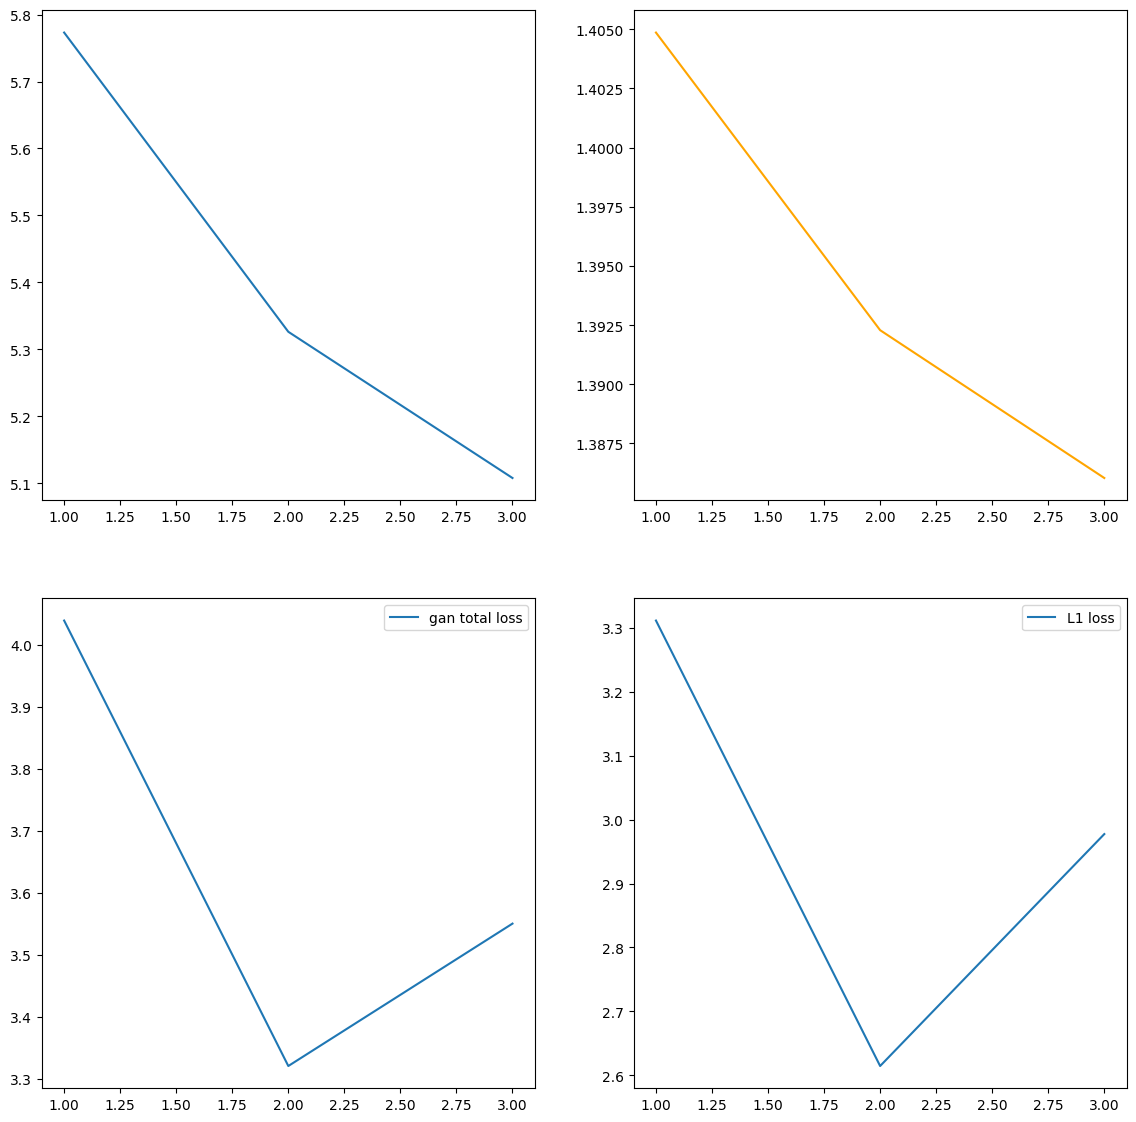

Seed :  2864

Start of epoch 4


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 5.269781 disc_loss : 1.39638 Bright coef : 0.8556282233946697
step 1 gen_loss : 4.769745 disc_loss : 1.376652 Bright coef : 0.9640795560813815
step 2 gen_loss : 4.374978 disc_loss : 1.4312458 Bright coef : 0.765247088034352
step 3 gen_loss : 2.9015932 disc_loss : 1.3690462 Bright coef : 0.7
step 4 gen_loss : 5.147617 disc_loss : 1.3932291 Bright coef : 1.0815248211599005
step 5 gen_loss : 5.43545 disc_loss : 1.3247378 Bright coef : 0.7
step 6 gen_loss : 5.7520156 disc_loss : 1.3599209 Bright coef : 1.1951423185179237
step 7 gen_loss : 3.7032547 disc_loss : 1.3739264 Bright coef : 1.2
step 8 gen_loss : 2.7829762 disc_loss : 1.403734 Bright coef : 0.7
step 9 gen_loss : 3.1999705 disc_loss : 1.3900068 Bright coef : 0.8900647378108553
step 10 gen_loss : 3.673603 disc_loss : 1.3671718 Bright coef : 0.7513788789659461
step 11 gen_loss : 3.821804 disc_loss : 1.3581239 Bright coef : 0.7709456717750585
step 12 gen_loss : 3.559103 disc_loss : 1.352313 Bright coef : 1.0570945721

step 107 gen_loss : 3.9720445 disc_loss : 1.3975489 Bright coef : 0.7
step 108 gen_loss : 4.9016705 disc_loss : 1.3189521 Bright coef : 0.9562061330104898
step 109 gen_loss : 3.1374903 disc_loss : 1.3988191 Bright coef : 0.7646426181900688
step 110 gen_loss : 5.000586 disc_loss : 1.4028213 Bright coef : 0.8206691447608829
step 111 gen_loss : 2.8387516 disc_loss : 1.3536668 Bright coef : 0.7068272667591536
step 112 gen_loss : 3.0633802 disc_loss : 1.3544157 Bright coef : 0.8987469092012877
step 113 gen_loss : 4.1767993 disc_loss : 1.3128662 Bright coef : 0.8723715663143143
step 114 gen_loss : 7.075486 disc_loss : 1.5571749 Bright coef : 1.1015872399959927
step 115 gen_loss : 5.577098 disc_loss : 1.350586 Bright coef : 0.7809634795756787
step 116 gen_loss : 5.3936467 disc_loss : 1.2716556 Bright coef : 0.7
step 117 gen_loss : 2.8356078 disc_loss : 1.4118279 Bright coef : 0.7
step 118 gen_loss : 3.2626653 disc_loss : 1.3670638 Bright coef : 0.7
step 119 gen_loss : 3.5435996 disc_loss : 1.

step 212 gen_loss : 3.5419428 disc_loss : 1.4464097 Bright coef : 0.7
step 213 gen_loss : 5.4659896 disc_loss : 1.373344 Bright coef : 0.7
step 214 gen_loss : 5.717845 disc_loss : 1.3599296 Bright coef : 1.1989714892225791
step 215 gen_loss : 3.2202148 disc_loss : 1.3796465 Bright coef : 0.7
step 216 gen_loss : 2.688104 disc_loss : 1.4899409 Bright coef : 0.7
step 217 gen_loss : 6.0360665 disc_loss : 1.3280119 Bright coef : 0.9086042541560939
step 218 gen_loss : 4.469919 disc_loss : 1.3802066 Bright coef : 0.9713124938233476
step 219 gen_loss : 3.0776558 disc_loss : 1.4106736 Bright coef : 0.7
step 220 gen_loss : 5.5624056 disc_loss : 1.4359511 Bright coef : 0.9833014938177503
step 221 gen_loss : 4.009783 disc_loss : 1.4026954 Bright coef : 1.1302313941854556
step 222 gen_loss : 6.1571264 disc_loss : 1.2327633 Bright coef : 0.9932871562119674
step 223 gen_loss : 5.41947 disc_loss : 1.4291396 Bright coef : 1.2
step 224 gen_loss : 2.9301372 disc_loss : 1.4588776 Bright coef : 0.729178934

step 316 gen_loss : 3.8447459 disc_loss : 1.327796 Bright coef : 0.7448726295462034
step 317 gen_loss : 5.300238 disc_loss : 1.2922537 Bright coef : 0.9653922309582511
step 318 gen_loss : 2.65911 disc_loss : 1.4615825 Bright coef : 0.7
step 319 gen_loss : 2.4094577 disc_loss : 1.4101975 Bright coef : 0.7755425936442557
step 320 gen_loss : 4.789166 disc_loss : 1.5651653 Bright coef : 0.9970969644067461
step 321 gen_loss : 6.910799 disc_loss : 1.1402156 Bright coef : 0.736333017797706
step 322 gen_loss : 7.455119 disc_loss : 1.133196 Bright coef : 1.0981530384764762
step 323 gen_loss : 5.7499456 disc_loss : 1.0092106 Bright coef : 0.8125489267342787
step 324 gen_loss : 13.467533 disc_loss : 1.777235 Bright coef : 0.9742680060269271
step 325 gen_loss : 5.913449 disc_loss : 1.2669637 Bright coef : 0.7
step 326 gen_loss : 4.0528708 disc_loss : 1.3293107 Bright coef : 0.729437382356275
step 327 gen_loss : 3.77703 disc_loss : 1.3554568 Bright coef : 0.9619271046815199
step 328 gen_loss : 8.53

step 419 gen_loss : 4.5718327 disc_loss : 1.2404683 Bright coef : 0.788559412163847
step 420 gen_loss : 6.3834934 disc_loss : 1.1661413 Bright coef : 0.9587264290655246
step 421 gen_loss : 3.0739698 disc_loss : 1.3053342 Bright coef : 0.9320520265886105
step 422 gen_loss : 2.778077 disc_loss : 1.4166603 Bright coef : 0.850143532188687
step 423 gen_loss : 4.1179867 disc_loss : 1.2481511 Bright coef : 0.807634988484907
step 424 gen_loss : 4.768941 disc_loss : 1.2017541 Bright coef : 1.0700822993421912
step 425 gen_loss : 9.728394 disc_loss : 0.70377374 Bright coef : 1.1204541398542531
step 426 gen_loss : 5.3893113 disc_loss : 1.7040908 Bright coef : 0.7
step 427 gen_loss : 5.4269047 disc_loss : 1.3428593 Bright coef : 0.7
step 428 gen_loss : 5.089619 disc_loss : 1.4295013 Bright coef : 0.9898335824457677
step 429 gen_loss : 3.0432494 disc_loss : 1.405036 Bright coef : 0.7
step 430 gen_loss : 6.560482 disc_loss : 1.2538098 Bright coef : 1.1221182592830872
step 431 gen_loss : 3.6061447 dis

step 521 gen_loss : 3.0934181 disc_loss : 1.3642163 Bright coef : 0.8574525951341833
step 522 gen_loss : 3.76161 disc_loss : 1.3553734 Bright coef : 0.7184710152365053
step 523 gen_loss : 2.8727825 disc_loss : 1.4220722 Bright coef : 0.7376295651385253
step 524 gen_loss : 8.540968 disc_loss : 1.0656171 Bright coef : 0.7514506840371519
step 525 gen_loss : 4.3459835 disc_loss : 1.3068204 Bright coef : 0.7
step 526 gen_loss : 3.059444 disc_loss : 1.4559002 Bright coef : 1.0587145191840326
step 527 gen_loss : 4.983584 disc_loss : 1.4983901 Bright coef : 0.7
step 528 gen_loss : 2.9931715 disc_loss : 1.3589797 Bright coef : 0.7
step 529 gen_loss : 8.058888 disc_loss : 1.3271232 Bright coef : 1.0499680576697998
step 530 gen_loss : 5.1975346 disc_loss : 1.1635433 Bright coef : 0.7
step 531 gen_loss : 3.342205 disc_loss : 1.203775 Bright coef : 0.7
step 532 gen_loss : 3.218413 disc_loss : 1.1951376 Bright coef : 0.9312346935393118
step 533 gen_loss : 3.8717763 disc_loss : 1.6232295 Bright coef 

step 625 gen_loss : 5.8243876 disc_loss : 1.3178475 Bright coef : 0.7
step 626 gen_loss : 3.485975 disc_loss : 1.388243 Bright coef : 0.8162619425623453
step 627 gen_loss : 4.009 disc_loss : 1.4537171 Bright coef : 0.7463786377461806
step 628 gen_loss : 4.195928 disc_loss : 1.2978748 Bright coef : 0.7813736328671173
step 629 gen_loss : 5.0795455 disc_loss : 1.3256152 Bright coef : 0.865135209959263
step 630 gen_loss : 3.2039046 disc_loss : 1.3155915 Bright coef : 0.836449907038618
step 631 gen_loss : 3.018931 disc_loss : 1.2597944 Bright coef : 0.7
step 632 gen_loss : 3.2240634 disc_loss : 1.4224203 Bright coef : 0.8948913274930186
step 633 gen_loss : 5.40814 disc_loss : 1.4542172 Bright coef : 0.7145902352391804
step 634 gen_loss : 5.048271 disc_loss : 1.2738984 Bright coef : 1.2
step 635 gen_loss : 4.5369067 disc_loss : 1.3971986 Bright coef : 0.7229769766949311
step 636 gen_loss : 2.5285416 disc_loss : 1.3872676 Bright coef : 0.7
step 637 gen_loss : 5.524809 disc_loss : 1.211664 Bri

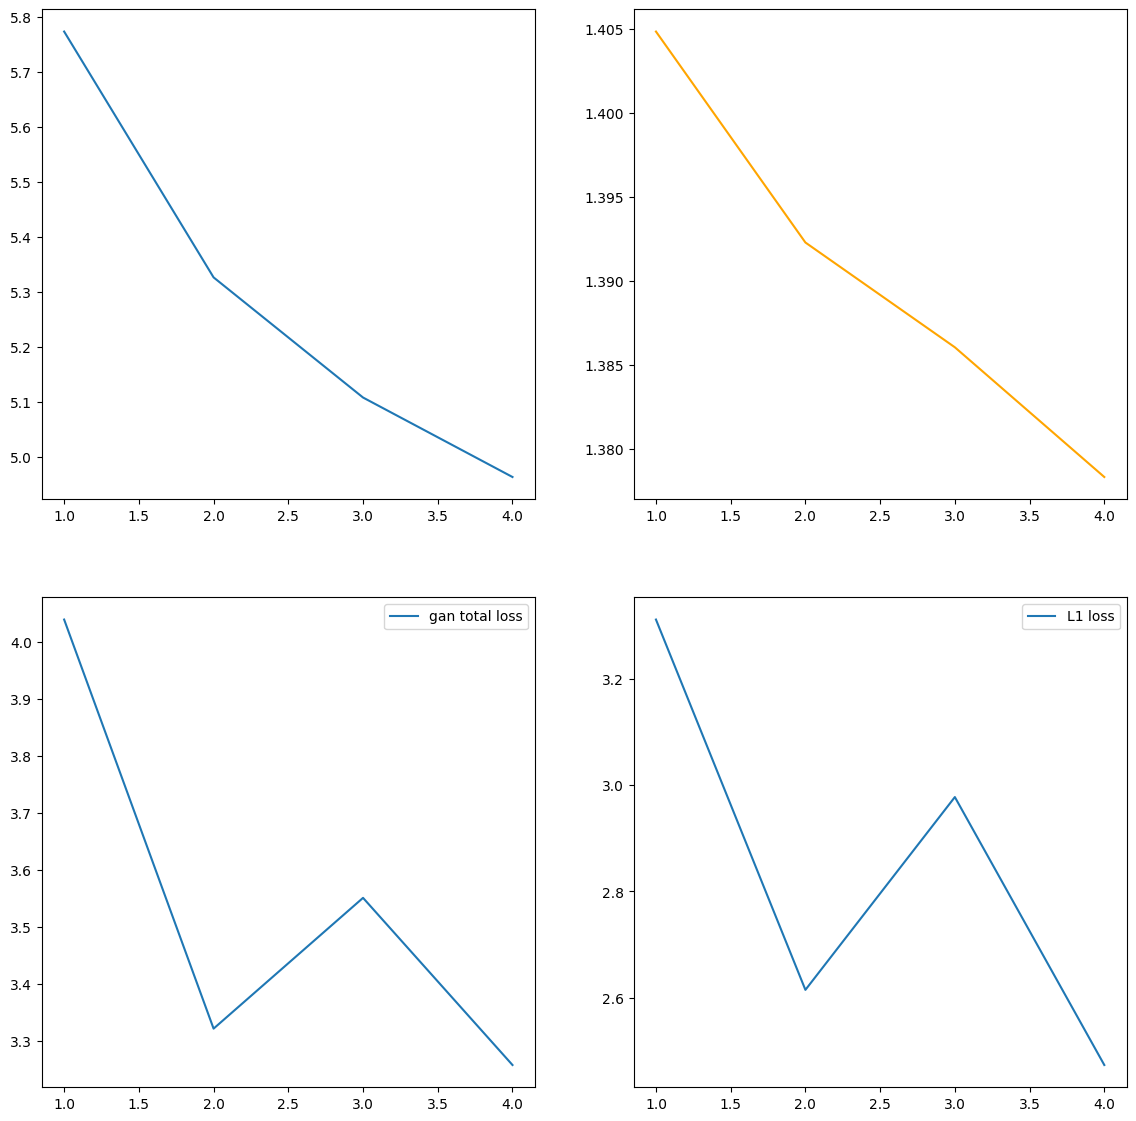

Seed :  5505

Start of epoch 5


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 3.4967306 disc_loss : 1.2244378 Bright coef : 0.7570281849267517
step 1 gen_loss : 3.6782672 disc_loss : 1.4382958 Bright coef : 0.859478094832175
step 2 gen_loss : 3.0866833 disc_loss : 1.4569178 Bright coef : 0.7
step 3 gen_loss : 3.139762 disc_loss : 1.2946985 Bright coef : 0.7
step 4 gen_loss : 3.0937717 disc_loss : 1.2869217 Bright coef : 0.8406132323098368
step 5 gen_loss : 3.6319594 disc_loss : 1.297333 Bright coef : 0.7
step 6 gen_loss : 9.52269 disc_loss : 0.8907387 Bright coef : 0.9462664401799905
step 7 gen_loss : 5.1294155 disc_loss : 1.1400337 Bright coef : 0.723466401852991
step 8 gen_loss : 7.907024 disc_loss : 0.8484807 Bright coef : 0.9282634696635382
step 9 gen_loss : 7.106196 disc_loss : 1.1222808 Bright coef : 1.1192501293554942
step 10 gen_loss : 3.787877 disc_loss : 2.4521713 Bright coef : 0.8047185685377262
step 11 gen_loss : 2.1836064 disc_loss : 1.6046369 Bright coef : 0.7017158198021598
step 12 gen_loss : 9.976425 disc_loss : 1.2942828 Bright

step 105 gen_loss : 2.5537815 disc_loss : 1.4075675 Bright coef : 0.7
step 106 gen_loss : 4.1509438 disc_loss : 1.4527992 Bright coef : 0.7
step 107 gen_loss : 2.6782415 disc_loss : 1.4462032 Bright coef : 0.767469007072815
step 108 gen_loss : 2.077238 disc_loss : 1.4504095 Bright coef : 0.7
step 109 gen_loss : 2.1830451 disc_loss : 1.3109925 Bright coef : 0.7407236157062959
step 110 gen_loss : 4.7594557 disc_loss : 1.5291351 Bright coef : 0.7
step 111 gen_loss : 2.5608635 disc_loss : 1.3705325 Bright coef : 0.7
step 112 gen_loss : 2.9021745 disc_loss : 1.4213744 Bright coef : 0.9353760497196831
step 113 gen_loss : 4.5990605 disc_loss : 1.4961306 Bright coef : 0.8127559776955127
step 114 gen_loss : 4.531582 disc_loss : 1.2607148 Bright coef : 1.085667113367034
step 115 gen_loss : 2.700449 disc_loss : 1.4036336 Bright coef : 0.9648779983586585
step 116 gen_loss : 3.214096 disc_loss : 1.2654055 Bright coef : 0.8095955265579464
step 117 gen_loss : 4.79755 disc_loss : 1.3302351 Bright coef

step 209 gen_loss : 7.3145146 disc_loss : 0.96935016 Bright coef : 0.7
step 210 gen_loss : 3.8337772 disc_loss : 1.1807898 Bright coef : 0.9829539348887941
step 211 gen_loss : 2.7928414 disc_loss : 1.4989221 Bright coef : 0.7
step 212 gen_loss : 4.0504847 disc_loss : 1.3230331 Bright coef : 0.7015055851904022
step 213 gen_loss : 2.9648938 disc_loss : 1.9076347 Bright coef : 0.7313596267152027
step 214 gen_loss : 4.411458 disc_loss : 1.0975701 Bright coef : 0.7942676436004493
step 215 gen_loss : 5.7535954 disc_loss : 1.5362382 Bright coef : 0.8633356515130534
step 216 gen_loss : 3.9341016 disc_loss : 1.2188966 Bright coef : 0.7
step 217 gen_loss : 4.499887 disc_loss : 1.5328217 Bright coef : 0.8756749883346653
step 218 gen_loss : 3.2176402 disc_loss : 1.5737684 Bright coef : 0.8270756486848223
step 219 gen_loss : 5.4081144 disc_loss : 1.6624838 Bright coef : 1.1749360336464527
step 220 gen_loss : 4.487185 disc_loss : 1.343264 Bright coef : 1.1040554519423669
step 221 gen_loss : 3.264411

step 312 gen_loss : 4.272668 disc_loss : 1.3542612 Bright coef : 1.0918434282124732
step 313 gen_loss : 4.797163 disc_loss : 1.2640588 Bright coef : 0.8206237140302931
step 314 gen_loss : 3.6472955 disc_loss : 1.5583225 Bright coef : 0.9939447748779088
step 315 gen_loss : 2.915584 disc_loss : 1.4353704 Bright coef : 0.7753435579939862
step 316 gen_loss : 2.7878845 disc_loss : 1.3846637 Bright coef : 0.7
step 317 gen_loss : 3.5863974 disc_loss : 1.3414531 Bright coef : 0.8456845543427866
step 318 gen_loss : 2.75505 disc_loss : 1.3007369 Bright coef : 0.9149501330409195
step 319 gen_loss : 5.286503 disc_loss : 1.3003604 Bright coef : 1.2
step 320 gen_loss : 2.4100149 disc_loss : 1.4434052 Bright coef : 0.9218027305814427
step 321 gen_loss : 3.7911148 disc_loss : 1.3788364 Bright coef : 1.0739822954642375
step 322 gen_loss : 4.3729553 disc_loss : 1.45439 Bright coef : 0.8288619069946264
step 323 gen_loss : 7.38112 disc_loss : 1.0487859 Bright coef : 0.7
step 324 gen_loss : 5.4829917 disc_

step 416 gen_loss : 5.3004518 disc_loss : 1.2457557 Bright coef : 0.9335946697082899
step 417 gen_loss : 3.385223 disc_loss : 1.4093342 Bright coef : 0.7
step 418 gen_loss : 4.8662224 disc_loss : 1.1913513 Bright coef : 0.7746002313722355
step 419 gen_loss : 3.3061862 disc_loss : 1.4778342 Bright coef : 0.7
step 420 gen_loss : 6.1467185 disc_loss : 1.8145189 Bright coef : 1.2
step 421 gen_loss : 4.698048 disc_loss : 1.3781779 Bright coef : 0.7
step 422 gen_loss : 5.4692426 disc_loss : 1.1218599 Bright coef : 1.030753129181861
step 423 gen_loss : 3.8094814 disc_loss : 1.2419333 Bright coef : 0.9048629669307247
step 424 gen_loss : 8.971194 disc_loss : 0.8081037 Bright coef : 0.9377120191793508
step 425 gen_loss : 3.505697 disc_loss : 1.3919815 Bright coef : 1.2
step 426 gen_loss : 4.087666 disc_loss : 0.937698 Bright coef : 0.783445061315144
step 427 gen_loss : 5.2291145 disc_loss : 1.183681 Bright coef : 0.9888760279277509
step 428 gen_loss : 3.2482457 disc_loss : 1.4341426 Bright coef 

step 520 gen_loss : 3.013649 disc_loss : 1.3882966 Bright coef : 0.7
step 521 gen_loss : 3.1187944 disc_loss : 1.4180899 Bright coef : 0.8014261494663937
step 522 gen_loss : 6.3938656 disc_loss : 0.9575204 Bright coef : 0.830350420391149
step 523 gen_loss : 4.837157 disc_loss : 1.4004822 Bright coef : 0.7
step 524 gen_loss : 4.374254 disc_loss : 0.98469704 Bright coef : 0.7658915478438664
step 525 gen_loss : 3.714345 disc_loss : 1.387418 Bright coef : 0.7
step 526 gen_loss : 2.475032 disc_loss : 1.4769058 Bright coef : 1.0921827062997418
step 527 gen_loss : 3.8384366 disc_loss : 1.1970812 Bright coef : 1.111258733553771
step 528 gen_loss : 7.433506 disc_loss : 1.3701928 Bright coef : 0.7
step 529 gen_loss : 2.6955035 disc_loss : 1.4427946 Bright coef : 0.7132906402650717
step 530 gen_loss : 3.4183455 disc_loss : 1.3592308 Bright coef : 1.0479895597961058
step 531 gen_loss : 2.7523348 disc_loss : 1.3314692 Bright coef : 0.7
step 532 gen_loss : 4.903607 disc_loss : 0.9510428 Bright coef 

step 624 gen_loss : 5.327406 disc_loss : 0.94819534 Bright coef : 0.7303296152510643
step 625 gen_loss : 3.832713 disc_loss : 1.2737584 Bright coef : 1.042254632469776
step 626 gen_loss : 3.5371132 disc_loss : 1.5080416 Bright coef : 0.8600795705765207
step 627 gen_loss : 5.415018 disc_loss : 1.6642952 Bright coef : 0.7
step 628 gen_loss : 3.8897438 disc_loss : 1.5555224 Bright coef : 0.7
step 629 gen_loss : 2.967436 disc_loss : 1.5442387 Bright coef : 0.7
step 630 gen_loss : 5.210031 disc_loss : 1.2948282 Bright coef : 0.7133451406619826
step 631 gen_loss : 3.062188 disc_loss : 1.4743977 Bright coef : 0.8286095480439112
step 632 gen_loss : 6.057031 disc_loss : 1.4202466 Bright coef : 1.0543792639772467
step 633 gen_loss : 3.409624 disc_loss : 1.7500323 Bright coef : 0.8378043300264788
step 634 gen_loss : 4.242592 disc_loss : 1.4124465 Bright coef : 0.7
step 635 gen_loss : 3.8480341 disc_loss : 1.3489687 Bright coef : 0.915705928679788
step 636 gen_loss : 2.7411067 disc_loss : 1.474636

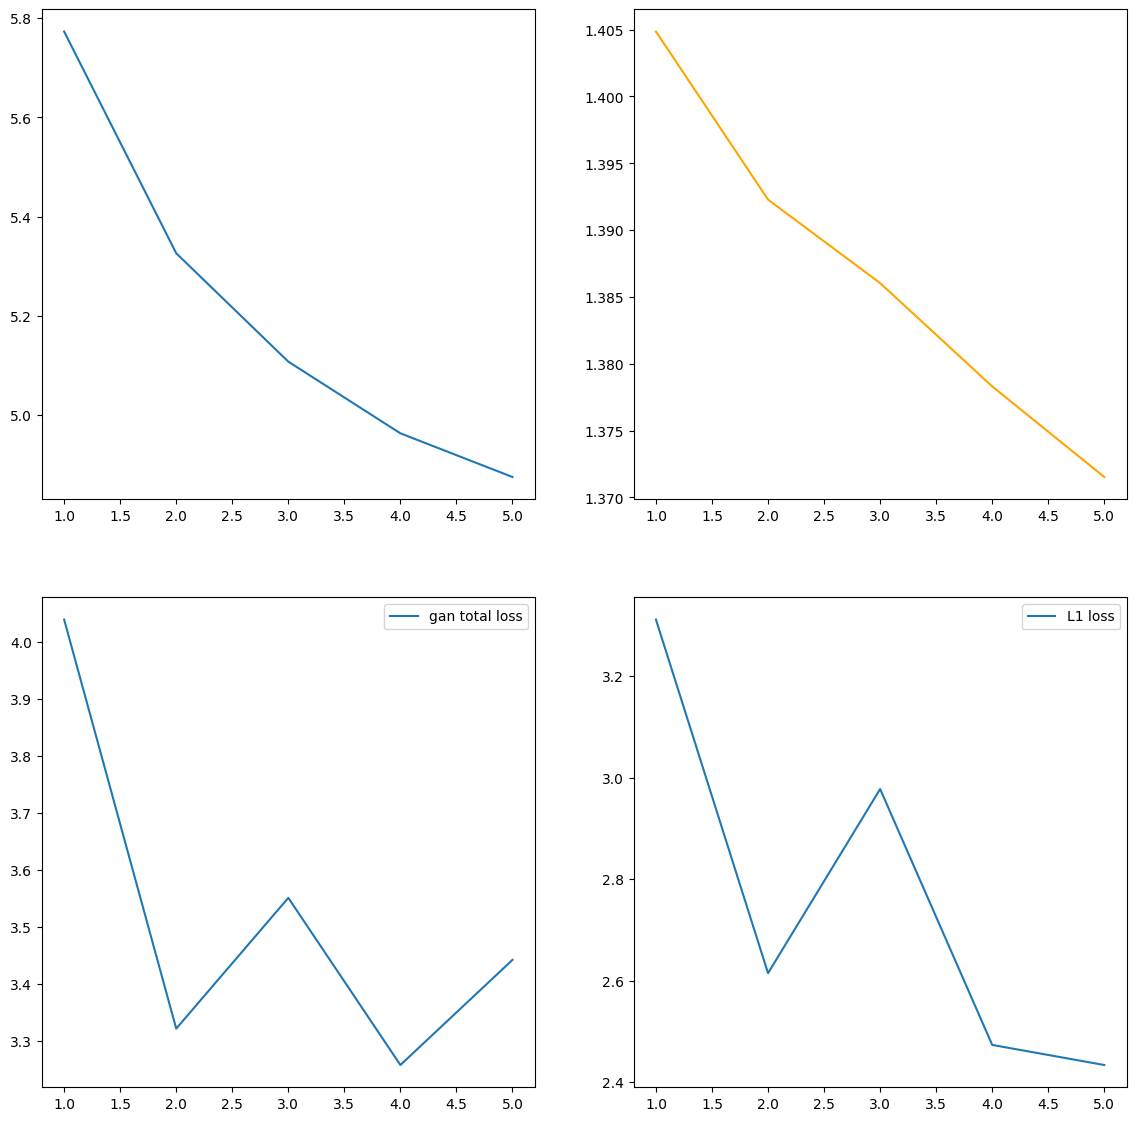

Seed :  4900

Start of epoch 6


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 4.5450687 disc_loss : 1.5159314 Bright coef : 0.9610119983198565
step 1 gen_loss : 3.5453515 disc_loss : 1.4021236 Bright coef : 0.7
step 2 gen_loss : 2.7557878 disc_loss : 1.4389049 Bright coef : 0.9167810515263326
step 3 gen_loss : 6.5958495 disc_loss : 0.915186 Bright coef : 0.7
step 4 gen_loss : 3.8576589 disc_loss : 1.4914546 Bright coef : 0.8944634543004613
step 5 gen_loss : 3.7853093 disc_loss : 1.4473333 Bright coef : 0.7916293523409585
step 6 gen_loss : 5.095232 disc_loss : 1.133793 Bright coef : 1.2
step 7 gen_loss : 4.9542236 disc_loss : 1.3946288 Bright coef : 0.7975551323904857
step 8 gen_loss : 4.381776 disc_loss : 1.2362361 Bright coef : 0.7
step 9 gen_loss : 4.3024554 disc_loss : 1.1939023 Bright coef : 0.7
step 10 gen_loss : 3.9349582 disc_loss : 1.4245951 Bright coef : 1.0157720326854038
step 11 gen_loss : 6.0670023 disc_loss : 1.3915403 Bright coef : 1.0180923394769597
step 12 gen_loss : 1.6454237 disc_loss : 1.6137745 Bright coef : 0.7
step 13 gen_

step 106 gen_loss : 3.515562 disc_loss : 1.4652984 Bright coef : 0.9264029738405026
step 107 gen_loss : 3.3935158 disc_loss : 1.4533174 Bright coef : 0.94126864586571
step 108 gen_loss : 3.7283306 disc_loss : 1.3974631 Bright coef : 0.7081860671992775
step 109 gen_loss : 4.9575276 disc_loss : 1.2933972 Bright coef : 1.2
step 110 gen_loss : 3.9237242 disc_loss : 1.3816099 Bright coef : 0.8402763127566827
step 111 gen_loss : 9.104004 disc_loss : 1.1820607 Bright coef : 1.0640334370496674
step 112 gen_loss : 5.865478 disc_loss : 1.1529038 Bright coef : 0.9241346182170319
step 113 gen_loss : 6.022186 disc_loss : 1.2065581 Bright coef : 0.7
step 114 gen_loss : 3.705837 disc_loss : 1.3995266 Bright coef : 0.7420819473420791
step 115 gen_loss : 3.830562 disc_loss : 1.4745479 Bright coef : 0.7839364020046204
step 116 gen_loss : 3.0642805 disc_loss : 1.3778367 Bright coef : 0.7
step 117 gen_loss : 3.1212237 disc_loss : 1.3084915 Bright coef : 0.7
step 118 gen_loss : 4.2570767 disc_loss : 1.2567

step 209 gen_loss : 3.6367023 disc_loss : 1.5960753 Bright coef : 0.8696577421693751
step 210 gen_loss : 5.6098843 disc_loss : 0.9818286 Bright coef : 1.02186218157471
step 211 gen_loss : 4.011519 disc_loss : 1.243488 Bright coef : 0.9339364865745301
step 212 gen_loss : 2.787574 disc_loss : 1.4232233 Bright coef : 0.8180000597675094
step 213 gen_loss : 3.007574 disc_loss : 1.4006181 Bright coef : 0.7
step 214 gen_loss : 3.0960293 disc_loss : 1.3287785 Bright coef : 0.7090449071418653
step 215 gen_loss : 5.3965406 disc_loss : 0.9142605 Bright coef : 0.7
step 216 gen_loss : 5.302444 disc_loss : 0.91367066 Bright coef : 0.9040446818996615
step 217 gen_loss : 4.3894987 disc_loss : 1.3300827 Bright coef : 0.8209438266742581
step 218 gen_loss : 3.415032 disc_loss : 1.3455741 Bright coef : 0.7
step 219 gen_loss : 2.9028358 disc_loss : 1.1885242 Bright coef : 0.7
step 220 gen_loss : 5.8841825 disc_loss : 0.73940665 Bright coef : 0.7
step 221 gen_loss : 3.6432056 disc_loss : 1.9667611 Bright co

step 314 gen_loss : 2.824988 disc_loss : 1.4040077 Bright coef : 0.8038167051075379
step 315 gen_loss : 3.1074455 disc_loss : 1.3842783 Bright coef : 0.7
step 316 gen_loss : 3.1281152 disc_loss : 1.25647 Bright coef : 0.7
step 317 gen_loss : 2.2580507 disc_loss : 1.3497393 Bright coef : 0.7
step 318 gen_loss : 3.98893 disc_loss : 1.1175277 Bright coef : 0.7
step 319 gen_loss : 3.8533974 disc_loss : 1.2775639 Bright coef : 0.7
step 320 gen_loss : 3.9297953 disc_loss : 1.4024276 Bright coef : 0.7
step 321 gen_loss : 2.4905913 disc_loss : 1.7773093 Bright coef : 0.7
step 322 gen_loss : 5.88748 disc_loss : 1.3069218 Bright coef : 1.0764585597163399
step 323 gen_loss : 3.1939688 disc_loss : 1.3641491 Bright coef : 0.7231157063574023
step 324 gen_loss : 4.504205 disc_loss : 1.1790731 Bright coef : 1.0033434386612372
step 325 gen_loss : 5.4733686 disc_loss : 0.92920834 Bright coef : 0.7
step 326 gen_loss : 3.3981624 disc_loss : 1.3560321 Bright coef : 1.0960962092960038
step 327 gen_loss : 3.

step 419 gen_loss : 4.7688694 disc_loss : 1.2461214 Bright coef : 0.8621892262571156
step 420 gen_loss : 3.3504794 disc_loss : 1.361697 Bright coef : 0.7
step 421 gen_loss : 3.5429573 disc_loss : 1.4245821 Bright coef : 0.7
step 422 gen_loss : 3.1968627 disc_loss : 1.4233093 Bright coef : 0.8707299815611623
step 423 gen_loss : 3.0237556 disc_loss : 1.407016 Bright coef : 0.9184560272691876
step 424 gen_loss : 2.457684 disc_loss : 1.3523041 Bright coef : 0.7
step 425 gen_loss : 6.5223055 disc_loss : 0.97441494 Bright coef : 0.7
step 426 gen_loss : 5.0175104 disc_loss : 1.3524816 Bright coef : 0.7
step 427 gen_loss : 4.0228615 disc_loss : 1.4139934 Bright coef : 0.7
step 428 gen_loss : 3.043058 disc_loss : 1.431475 Bright coef : 0.7
step 429 gen_loss : 3.470423 disc_loss : 1.4732623 Bright coef : 1.115636907270597
step 430 gen_loss : 3.05519 disc_loss : 1.4620547 Bright coef : 1.0465394167257973
step 431 gen_loss : 4.746248 disc_loss : 1.2717514 Bright coef : 0.7545021824896373
step 432 

step 525 gen_loss : 3.162751 disc_loss : 1.5520924 Bright coef : 0.9430222564913054
step 526 gen_loss : 5.395275 disc_loss : 1.5078937 Bright coef : 0.8833911518211868
step 527 gen_loss : 2.5301754 disc_loss : 1.4991604 Bright coef : 0.9645093924716679
step 528 gen_loss : 3.768607 disc_loss : 1.3673337 Bright coef : 0.9662904895615279
step 529 gen_loss : 5.2138658 disc_loss : 1.1887245 Bright coef : 0.8186896883940862
step 530 gen_loss : 2.5900648 disc_loss : 1.3613039 Bright coef : 0.839464872882202
step 531 gen_loss : 2.2097983 disc_loss : 1.6137607 Bright coef : 0.8375464524124839
step 532 gen_loss : 9.293694 disc_loss : 1.4181957 Bright coef : 1.084281661683106
step 533 gen_loss : 3.256722 disc_loss : 1.4506335 Bright coef : 0.8060191928495626
step 534 gen_loss : 4.4575768 disc_loss : 1.193589 Bright coef : 0.7877178215225504
step 535 gen_loss : 6.6256433 disc_loss : 1.168279 Bright coef : 0.7
step 536 gen_loss : 8.409112 disc_loss : 1.248527 Bright coef : 1.2
step 537 gen_loss : 3

step 629 gen_loss : 4.6456137 disc_loss : 1.4748653 Bright coef : 1.053027778539932
step 630 gen_loss : 4.151062 disc_loss : 1.2580036 Bright coef : 0.7519121777983457
step 631 gen_loss : 3.6453536 disc_loss : 1.2493575 Bright coef : 0.7
step 632 gen_loss : 5.0513372 disc_loss : 1.3886204 Bright coef : 0.9892469340247899
step 633 gen_loss : 3.0969093 disc_loss : 1.4258482 Bright coef : 0.7
step 634 gen_loss : 3.3228054 disc_loss : 1.4004984 Bright coef : 0.7
step 635 gen_loss : 7.759004 disc_loss : 0.71438015 Bright coef : 0.7
step 636 gen_loss : 3.2228675 disc_loss : 1.3642569 Bright coef : 1.1309795155137004
step 637 gen_loss : 2.6608732 disc_loss : 1.4233081 Bright coef : 0.7
step 638 gen_loss : 3.155714 disc_loss : 1.3221533 Bright coef : 0.7557564611076625
step 639 gen_loss : 2.3992279 disc_loss : 1.4589499 Bright coef : 0.8847220961088237
d_org.jpg d_org.jpg
gearth_13_09_004_org.jpg gearth_13_09_004_org.jpg
gearth_13_09_010_org.jpg gearth_13_09_010_org.jpg
gearth_13_09_016_org.jp

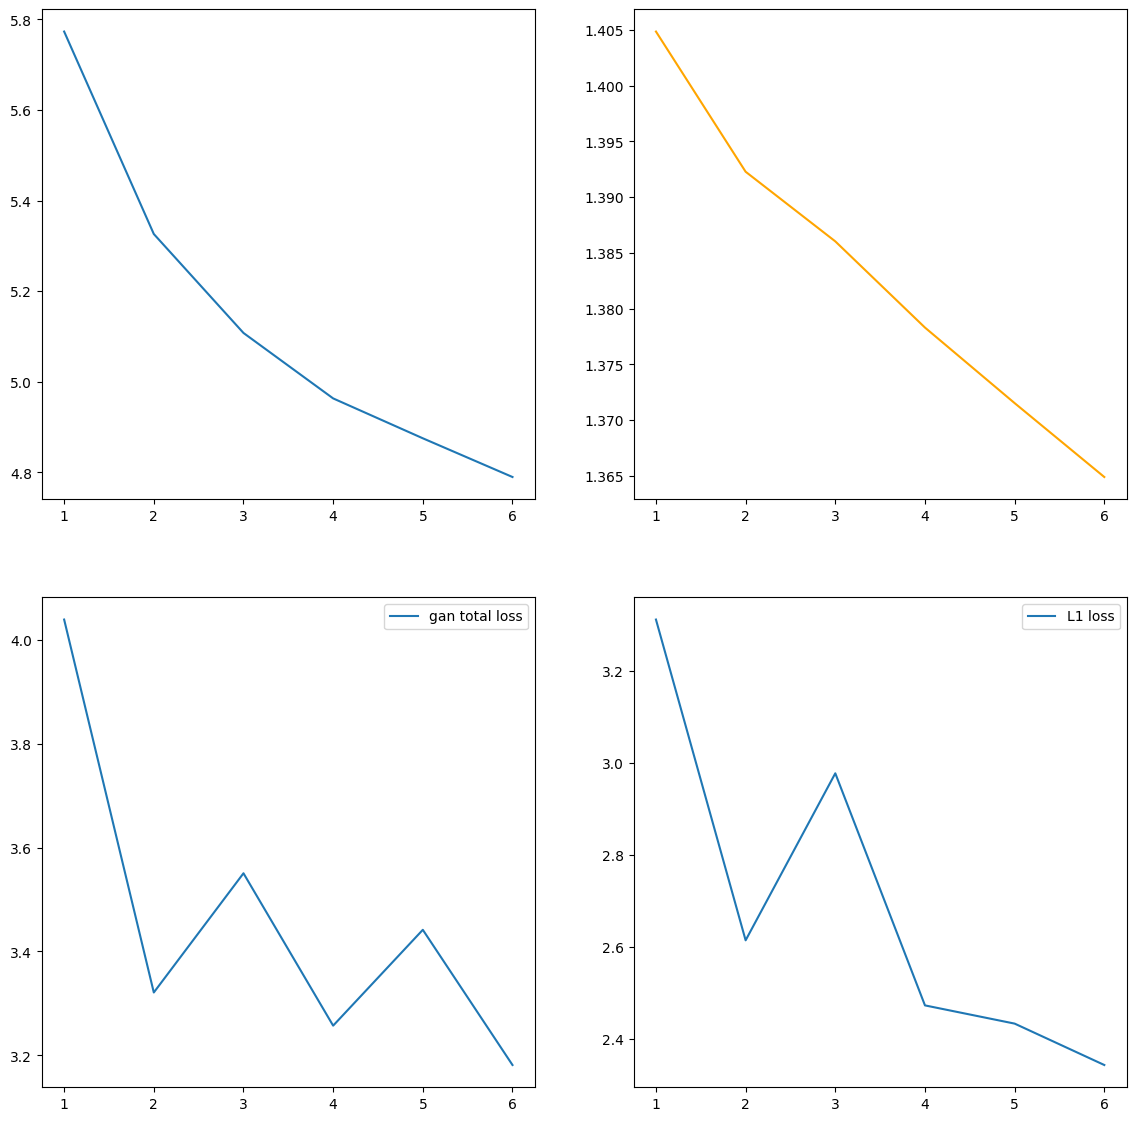

Seed :  9923

Start of epoch 7


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 4.1802025 disc_loss : 1.1840444 Bright coef : 0.7
step 1 gen_loss : 4.4630184 disc_loss : 1.3834279 Bright coef : 0.7
step 2 gen_loss : 3.9327328 disc_loss : 1.347324 Bright coef : 0.8875419410260865
step 3 gen_loss : 7.16468 disc_loss : 1.5432333 Bright coef : 0.9873463744961262
step 4 gen_loss : 2.9358964 disc_loss : 1.6637719 Bright coef : 0.7970594544001257
step 5 gen_loss : 6.2967205 disc_loss : 1.1111304 Bright coef : 0.9311837783062085
step 6 gen_loss : 4.7730947 disc_loss : 1.4948634 Bright coef : 1.1754123364562554
step 7 gen_loss : 5.3345385 disc_loss : 1.3936315 Bright coef : 0.7
step 8 gen_loss : 5.746202 disc_loss : 1.1862662 Bright coef : 0.8148666803060121
step 9 gen_loss : 5.4907494 disc_loss : 1.2783291 Bright coef : 0.8137708182105928
step 10 gen_loss : 3.649353 disc_loss : 1.4854195 Bright coef : 0.7887240575679197
step 11 gen_loss : 3.8623042 disc_loss : 1.3636101 Bright coef : 0.7
step 12 gen_loss : 4.9449897 disc_loss : 1.0020208 Bright coef : 0.

step 106 gen_loss : 2.3917308 disc_loss : 1.4528042 Bright coef : 0.7
step 107 gen_loss : 2.7459059 disc_loss : 1.2800875 Bright coef : 0.7330788639868179
step 108 gen_loss : 2.705893 disc_loss : 1.3217375 Bright coef : 0.8650455017805995
step 109 gen_loss : 3.6600857 disc_loss : 1.361525 Bright coef : 0.9180077100569708
step 110 gen_loss : 2.9662094 disc_loss : 1.303122 Bright coef : 0.7
step 111 gen_loss : 3.78716 disc_loss : 1.4260497 Bright coef : 0.98111747589033
step 112 gen_loss : 2.8404412 disc_loss : 1.4202783 Bright coef : 0.7
step 113 gen_loss : 2.5008335 disc_loss : 1.4814787 Bright coef : 0.7
step 114 gen_loss : 3.341017 disc_loss : 1.2366097 Bright coef : 0.7986910691771865
step 115 gen_loss : 3.6213138 disc_loss : 1.2542056 Bright coef : 0.8335284080155605
step 116 gen_loss : 3.5592856 disc_loss : 1.4026664 Bright coef : 0.8426095477724684
step 117 gen_loss : 7.16556 disc_loss : 1.0538416 Bright coef : 1.00372528711378
step 118 gen_loss : 2.9497752 disc_loss : 1.4103307 

step 209 gen_loss : 2.6874704 disc_loss : 1.5047309 Bright coef : 0.7
step 210 gen_loss : 4.390675 disc_loss : 1.2210772 Bright coef : 0.7
step 211 gen_loss : 4.2463384 disc_loss : 1.3557162 Bright coef : 1.1717586913772784
step 212 gen_loss : 4.8432884 disc_loss : 0.9796097 Bright coef : 0.823805356196458
step 213 gen_loss : 8.081404 disc_loss : 0.7753293 Bright coef : 0.7
step 214 gen_loss : 6.585446 disc_loss : 1.2862761 Bright coef : 0.9408151032563886
step 215 gen_loss : 3.0531445 disc_loss : 1.4392374 Bright coef : 0.8201991600713879
step 216 gen_loss : 4.493286 disc_loss : 1.3841789 Bright coef : 0.9988921180739292
step 217 gen_loss : 5.2439365 disc_loss : 1.0238473 Bright coef : 0.8846649669218071
step 218 gen_loss : 2.2997382 disc_loss : 1.4069057 Bright coef : 0.7
step 219 gen_loss : 3.8063715 disc_loss : 1.3283849 Bright coef : 1.0261581543870637
step 220 gen_loss : 2.8714857 disc_loss : 1.4101927 Bright coef : 0.764622802119506
step 221 gen_loss : 3.3441153 disc_loss : 1.34

step 312 gen_loss : 4.7866855 disc_loss : 1.2831248 Bright coef : 0.7
step 313 gen_loss : 4.330993 disc_loss : 1.2452652 Bright coef : 0.9148558012023087
step 314 gen_loss : 6.1157556 disc_loss : 1.1570029 Bright coef : 0.9125565387299717
step 315 gen_loss : 3.5278656 disc_loss : 1.4703557 Bright coef : 1.0821482601925765
step 316 gen_loss : 11.394391 disc_loss : 0.65091693 Bright coef : 0.8607183857328812
step 317 gen_loss : 4.376134 disc_loss : 1.3706899 Bright coef : 0.7436435315091547
step 318 gen_loss : 5.9332495 disc_loss : 1.3495626 Bright coef : 0.9296594750633462
step 319 gen_loss : 4.2223344 disc_loss : 1.1765071 Bright coef : 0.7
step 320 gen_loss : 3.6668696 disc_loss : 1.1152959 Bright coef : 0.799548467290793
step 321 gen_loss : 3.644874 disc_loss : 1.1797346 Bright coef : 0.7505129294629557
step 322 gen_loss : 5.5023584 disc_loss : 0.8268572 Bright coef : 1.2
step 323 gen_loss : 3.3212795 disc_loss : 1.4566513 Bright coef : 0.8268618105672682
step 324 gen_loss : 5.152529

step 416 gen_loss : 5.68986 disc_loss : 0.7082921 Bright coef : 0.7
step 417 gen_loss : 3.6022663 disc_loss : 1.4592012 Bright coef : 0.7
step 418 gen_loss : 2.6578908 disc_loss : 1.3842498 Bright coef : 1.0435915956298494
step 419 gen_loss : 3.621035 disc_loss : 1.9454787 Bright coef : 0.7
step 420 gen_loss : 2.98467 disc_loss : 1.4051894 Bright coef : 0.7
step 421 gen_loss : 3.0254288 disc_loss : 1.388635 Bright coef : 0.75839627224777
step 422 gen_loss : 6.0059643 disc_loss : 1.6255186 Bright coef : 0.7
step 423 gen_loss : 2.550959 disc_loss : 1.4133754 Bright coef : 0.7048432668281832
step 424 gen_loss : 2.8172584 disc_loss : 1.4040256 Bright coef : 0.7
step 425 gen_loss : 2.7025442 disc_loss : 1.4006838 Bright coef : 0.9923978826189226
step 426 gen_loss : 2.7560713 disc_loss : 1.3958988 Bright coef : 0.7
step 427 gen_loss : 4.265093 disc_loss : 1.1870252 Bright coef : 0.7
step 428 gen_loss : 2.3525524 disc_loss : 1.3462608 Bright coef : 0.7
step 429 gen_loss : 5.5999594 disc_loss 

step 518 gen_loss : 5.4142385 disc_loss : 1.179934 Bright coef : 0.7
step 519 gen_loss : 2.599249 disc_loss : 1.5163813 Bright coef : 0.8951346909698146
step 520 gen_loss : 2.744979 disc_loss : 1.3326498 Bright coef : 0.7977598701287446
step 521 gen_loss : 4.377511 disc_loss : 1.0603628 Bright coef : 0.7
step 522 gen_loss : 6.9492974 disc_loss : 0.66063833 Bright coef : 0.7
step 523 gen_loss : 4.063882 disc_loss : 1.1116786 Bright coef : 1.071006713984281
step 524 gen_loss : 5.0915203 disc_loss : 1.2492747 Bright coef : 0.9235816701577996
step 525 gen_loss : 5.1129117 disc_loss : 1.1569965 Bright coef : 0.7068334201016235
step 526 gen_loss : 5.370748 disc_loss : 1.2004236 Bright coef : 1.1055767807162191
step 527 gen_loss : 3.7981415 disc_loss : 1.0875418 Bright coef : 0.760520310078765
step 528 gen_loss : 4.6058292 disc_loss : 1.6351546 Bright coef : 0.8985458494216337
step 529 gen_loss : 2.9196935 disc_loss : 1.7006066 Bright coef : 0.7
step 530 gen_loss : 5.416815 disc_loss : 1.7195

step 622 gen_loss : 3.2169466 disc_loss : 1.531322 Bright coef : 0.7296980965929284
step 623 gen_loss : 3.903859 disc_loss : 1.2933509 Bright coef : 1.1032007555821854
step 624 gen_loss : 4.3880186 disc_loss : 1.3004631 Bright coef : 1.0701177008886502
step 625 gen_loss : 4.239128 disc_loss : 1.6588112 Bright coef : 1.0529804508500182
step 626 gen_loss : 3.1073837 disc_loss : 1.2553915 Bright coef : 0.7870692192332281
step 627 gen_loss : 5.7105465 disc_loss : 1.2224133 Bright coef : 0.8453439250387478
step 628 gen_loss : 3.162681 disc_loss : 1.4379269 Bright coef : 0.7
step 629 gen_loss : 2.8518133 disc_loss : 1.6107931 Bright coef : 0.7488119228668445
step 630 gen_loss : 4.6888943 disc_loss : 1.4622613 Bright coef : 0.8373725451823076
step 631 gen_loss : 9.930586 disc_loss : 0.5810056 Bright coef : 0.9959849832533902
step 632 gen_loss : 4.3387723 disc_loss : 1.2433689 Bright coef : 0.8894882986232744
step 633 gen_loss : 4.503436 disc_loss : 1.2557076 Bright coef : 0.7
step 634 gen_los

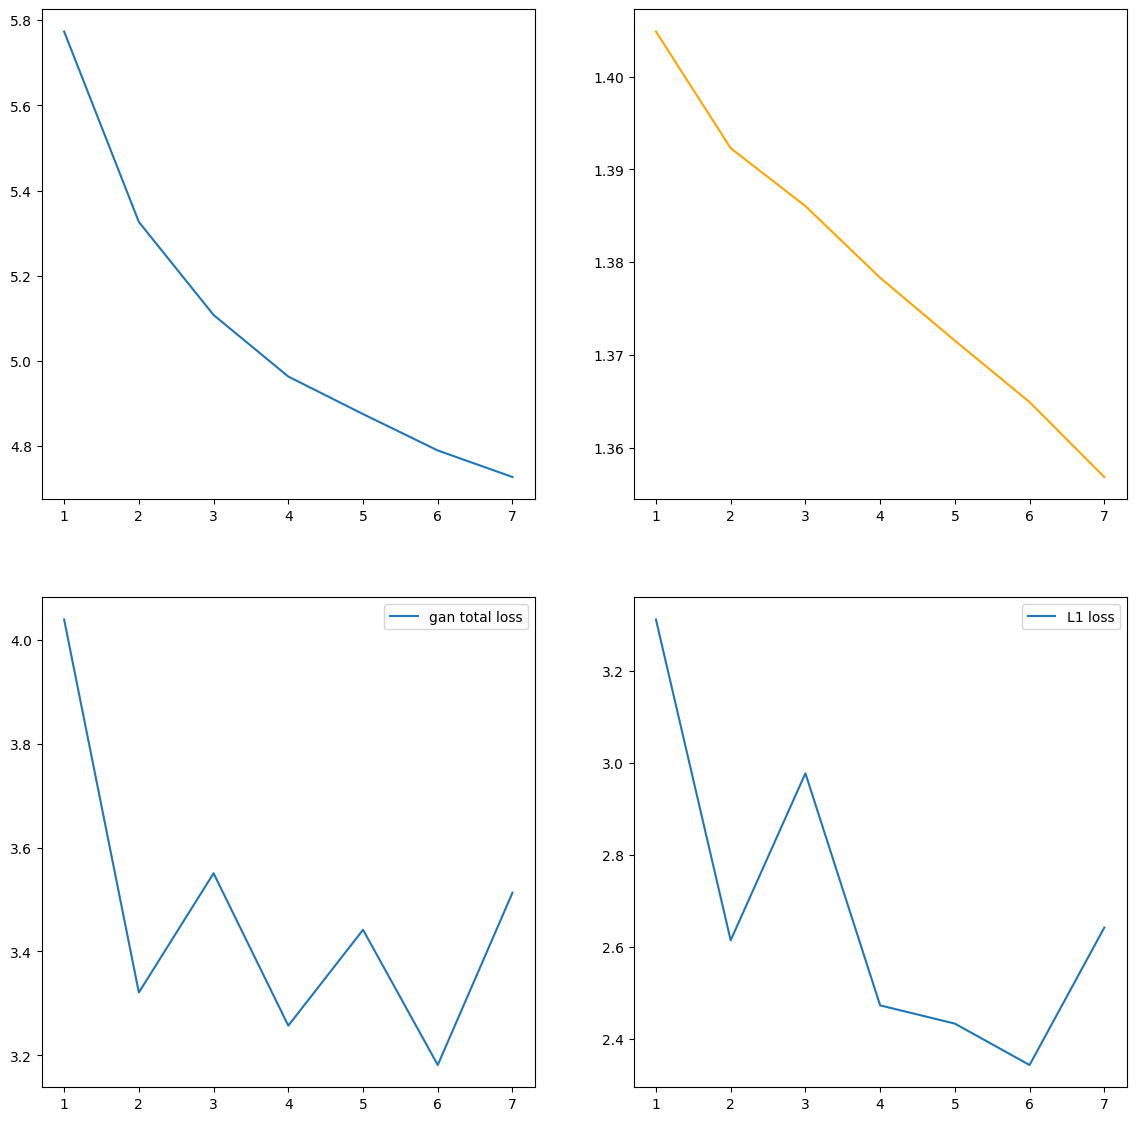

Seed :  1199

Start of epoch 8


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 7.955919 disc_loss : 0.8212615 Bright coef : 0.8371627992297501
step 1 gen_loss : 5.8212776 disc_loss : 1.3091335 Bright coef : 0.9984428483152191
step 2 gen_loss : 5.3111076 disc_loss : 0.47561762 Bright coef : 0.7
step 3 gen_loss : 4.4162226 disc_loss : 1.5656668 Bright coef : 0.8696850178782075
step 4 gen_loss : 5.3785753 disc_loss : 0.79829144 Bright coef : 0.889733713394294
step 5 gen_loss : 3.2771792 disc_loss : 1.567041 Bright coef : 0.7
step 6 gen_loss : 3.6368308 disc_loss : 1.6207442 Bright coef : 0.7
step 7 gen_loss : 3.580498 disc_loss : 1.1583233 Bright coef : 0.7402795138245707
step 8 gen_loss : 4.4205675 disc_loss : 0.79088897 Bright coef : 0.7570555112999252
step 9 gen_loss : 3.967384 disc_loss : 1.1504521 Bright coef : 0.8146788035936704
step 10 gen_loss : 4.371511 disc_loss : 1.2713056 Bright coef : 0.8107042156006317
step 11 gen_loss : 3.7800608 disc_loss : 1.1278124 Bright coef : 0.8075980073181962
step 12 gen_loss : 4.0197687 disc_loss : 1.6013614

step 106 gen_loss : 7.2177286 disc_loss : 1.0200186 Bright coef : 1.0002052043789311
step 107 gen_loss : 3.3698587 disc_loss : 1.3883117 Bright coef : 0.7290526020168401
step 108 gen_loss : 4.253508 disc_loss : 1.250082 Bright coef : 1.1425426020153213
step 109 gen_loss : 3.4049177 disc_loss : 1.542783 Bright coef : 0.911358565751623
step 110 gen_loss : 5.0661945 disc_loss : 1.1883357 Bright coef : 0.7
step 111 gen_loss : 4.9465513 disc_loss : 1.2288187 Bright coef : 0.7185144456031913
step 112 gen_loss : 6.231974 disc_loss : 0.9643999 Bright coef : 1.1213857818263813
step 113 gen_loss : 3.0300407 disc_loss : 1.5015693 Bright coef : 0.8626041961194468
step 114 gen_loss : 3.3062677 disc_loss : 1.4872528 Bright coef : 1.0997806691188443
step 115 gen_loss : 6.040914 disc_loss : 1.0726503 Bright coef : 1.0620432758785574
step 116 gen_loss : 3.7539701 disc_loss : 0.8065127 Bright coef : 0.7
step 117 gen_loss : 2.7565863 disc_loss : 1.4279114 Bright coef : 0.7223009733677173
step 118 gen_los

step 210 gen_loss : 2.9542773 disc_loss : 1.4901929 Bright coef : 0.874391218901218
step 211 gen_loss : 2.831039 disc_loss : 1.3311892 Bright coef : 0.7
step 212 gen_loss : 3.0495896 disc_loss : 1.5581899 Bright coef : 0.8971362330174375
step 213 gen_loss : 7.008626 disc_loss : 0.9121939 Bright coef : 0.9428588967682503
step 214 gen_loss : 3.57085 disc_loss : 1.3648914 Bright coef : 1.1806615492671337
step 215 gen_loss : 4.123591 disc_loss : 1.323278 Bright coef : 0.9172519706778232
step 216 gen_loss : 4.3605146 disc_loss : 1.0852948 Bright coef : 0.9050450456490414
step 217 gen_loss : 4.032811 disc_loss : 1.1120114 Bright coef : 0.7
step 218 gen_loss : 2.7898295 disc_loss : 1.4910582 Bright coef : 0.7
step 219 gen_loss : 2.69054 disc_loss : 1.2941418 Bright coef : 0.8881250253814952
step 220 gen_loss : 3.449966 disc_loss : 1.4368827 Bright coef : 0.8768124423435546
step 221 gen_loss : 4.667576 disc_loss : 1.083524 Bright coef : 0.7
step 222 gen_loss : 3.5270998 disc_loss : 1.1165323 B

step 314 gen_loss : 3.8500657 disc_loss : 1.1613023 Bright coef : 0.8800400466412688
step 315 gen_loss : 4.011868 disc_loss : 1.3889885 Bright coef : 0.7453738542375601
step 316 gen_loss : 4.555563 disc_loss : 1.3671161 Bright coef : 0.773034770339656
step 317 gen_loss : 4.456872 disc_loss : 0.86835647 Bright coef : 0.7
step 318 gen_loss : 6.910198 disc_loss : 1.2967341 Bright coef : 0.9793972135749404
step 319 gen_loss : 3.2704706 disc_loss : 1.5364031 Bright coef : 0.7884851659834479
step 320 gen_loss : 4.538067 disc_loss : 1.552267 Bright coef : 1.0974372908221663
step 321 gen_loss : 6.426726 disc_loss : 1.1455421 Bright coef : 0.7506433185245053
step 322 gen_loss : 14.163766 disc_loss : 0.6769911 Bright coef : 0.8452617872367734
step 323 gen_loss : 2.9333358 disc_loss : 1.2975574 Bright coef : 0.8093581037253633
step 324 gen_loss : 4.106954 disc_loss : 1.3865932 Bright coef : 0.7923734260276114
step 325 gen_loss : 2.998415 disc_loss : 1.0257814 Bright coef : 0.9579850874741215
step

step 417 gen_loss : 3.4241304 disc_loss : 1.3953459 Bright coef : 1.1526803805178751
step 418 gen_loss : 3.1508203 disc_loss : 1.416814 Bright coef : 0.8584920904460804
step 419 gen_loss : 2.813673 disc_loss : 1.334611 Bright coef : 0.7
step 420 gen_loss : 4.468121 disc_loss : 1.1313491 Bright coef : 0.7
step 421 gen_loss : 2.5170498 disc_loss : 1.2686772 Bright coef : 0.7
step 422 gen_loss : 6.7557898 disc_loss : 0.9767549 Bright coef : 1.0817607146107768
step 423 gen_loss : 6.8559957 disc_loss : 0.8729442 Bright coef : 0.8999642540636822
step 424 gen_loss : 3.6921976 disc_loss : 1.38255 Bright coef : 0.7378918498522387
step 425 gen_loss : 5.3657484 disc_loss : 0.8652741 Bright coef : 0.818962902490262
step 426 gen_loss : 3.9852338 disc_loss : 1.1423804 Bright coef : 0.7133972094131428
step 427 gen_loss : 3.6291537 disc_loss : 1.4806614 Bright coef : 1.0191052210956855
step 428 gen_loss : 3.7491896 disc_loss : 1.7763971 Bright coef : 0.7560654212999319
step 429 gen_loss : 3.526342 dis

step 520 gen_loss : 2.7895188 disc_loss : 1.5143918 Bright coef : 0.7
step 521 gen_loss : 3.730534 disc_loss : 1.4301708 Bright coef : 0.7
step 522 gen_loss : 6.570175 disc_loss : 0.7555512 Bright coef : 0.839118866526931
step 523 gen_loss : 5.050605 disc_loss : 1.4251175 Bright coef : 1.2
step 524 gen_loss : 6.3500476 disc_loss : 1.1468961 Bright coef : 1.2
step 525 gen_loss : 4.514889 disc_loss : 1.0652417 Bright coef : 0.7
step 526 gen_loss : 5.1269746 disc_loss : 0.89265054 Bright coef : 0.7510785689570817
step 527 gen_loss : 4.2965903 disc_loss : 0.8204143 Bright coef : 0.9973125040249106
step 528 gen_loss : 3.33109 disc_loss : 1.1427535 Bright coef : 0.7
step 529 gen_loss : 4.212392 disc_loss : 1.435842 Bright coef : 0.7412449373846516
step 530 gen_loss : 3.9477403 disc_loss : 1.6771102 Bright coef : 0.7591021383305254
step 531 gen_loss : 3.2769122 disc_loss : 1.6725132 Bright coef : 0.7
step 532 gen_loss : 5.0766125 disc_loss : 1.1634817 Bright coef : 1.2
step 533 gen_loss : 3.3

step 624 gen_loss : 3.336566 disc_loss : 1.3729886 Bright coef : 0.7
step 625 gen_loss : 3.1125946 disc_loss : 0.9699248 Bright coef : 0.8849078888500239
step 626 gen_loss : 4.0110507 disc_loss : 1.0938358 Bright coef : 0.7
step 627 gen_loss : 3.898909 disc_loss : 1.119799 Bright coef : 0.7934068665265346
step 628 gen_loss : 4.0116563 disc_loss : 1.0451332 Bright coef : 0.748638076447917
step 629 gen_loss : 7.278463 disc_loss : 1.1884876 Bright coef : 1.0591860169608478
step 630 gen_loss : 4.2519903 disc_loss : 0.85473484 Bright coef : 0.7511407536768518
step 631 gen_loss : 6.587006 disc_loss : 0.52914274 Bright coef : 0.8083477883235972
step 632 gen_loss : 4.903797 disc_loss : 0.64441484 Bright coef : 0.7
step 633 gen_loss : 8.5927925 disc_loss : 0.92449236 Bright coef : 0.7336865803771186
step 634 gen_loss : 7.3090887 disc_loss : 0.9910235 Bright coef : 0.8455016023165386
step 635 gen_loss : 4.5958023 disc_loss : 1.6117455 Bright coef : 0.9042531581649536
step 636 gen_loss : 5.245157

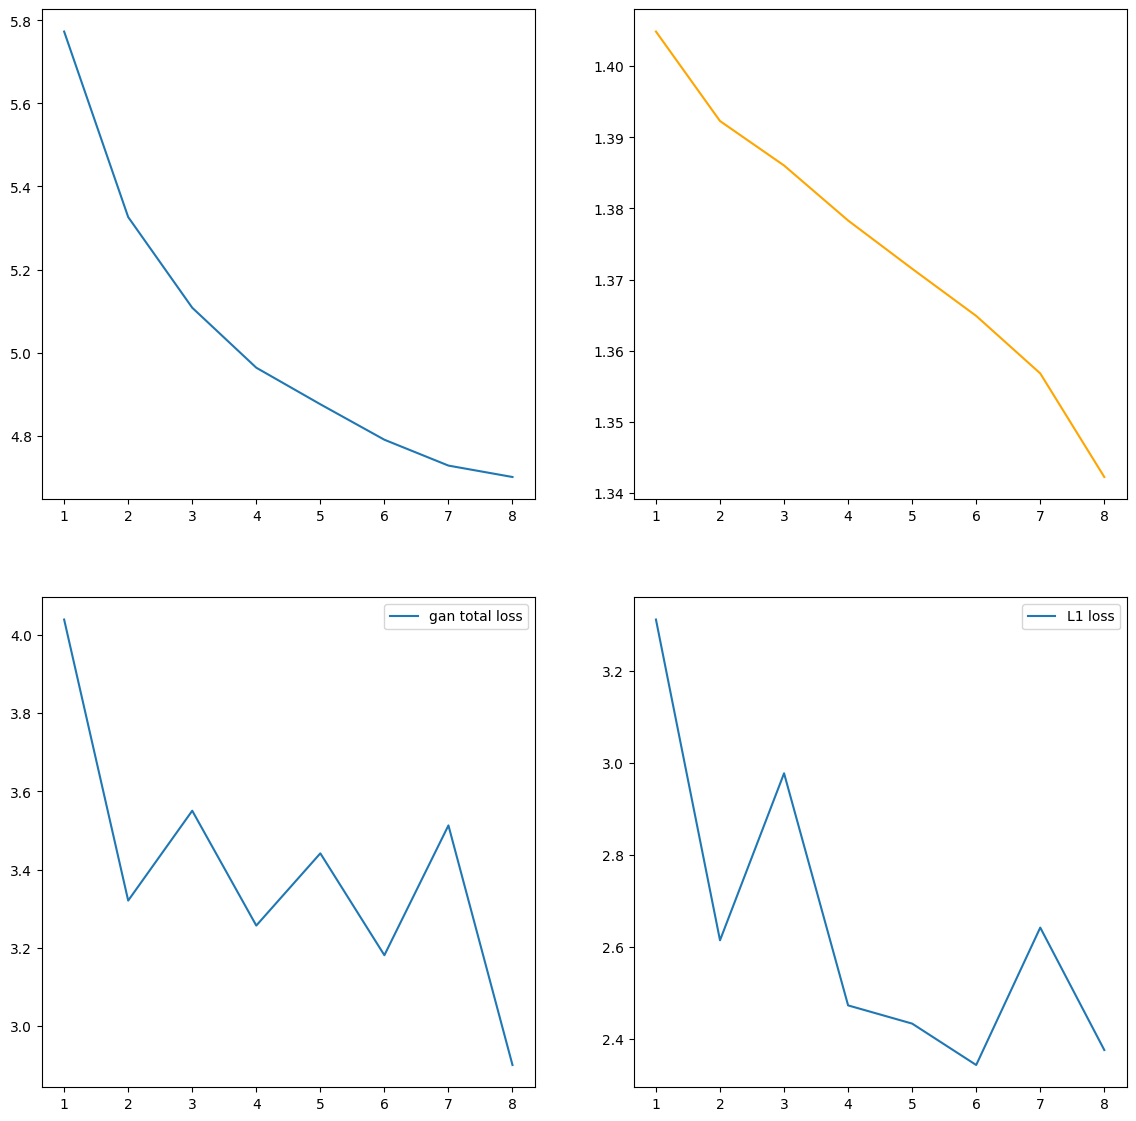

Seed :  1457

Start of epoch 9


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 4.6276917 disc_loss : 0.68448746 Bright coef : 0.7
step 1 gen_loss : 3.3888476 disc_loss : 1.2293022 Bright coef : 1.0758212436654477
step 2 gen_loss : 4.1502237 disc_loss : 1.0263152 Bright coef : 0.7
step 3 gen_loss : 3.7310233 disc_loss : 1.4520438 Bright coef : 0.7
step 4 gen_loss : 3.8480966 disc_loss : 1.3380601 Bright coef : 1.0182304437537986
step 5 gen_loss : 6.370054 disc_loss : 1.031345 Bright coef : 1.0306679818117706
step 6 gen_loss : 3.4797938 disc_loss : 1.6400127 Bright coef : 0.7
step 7 gen_loss : 3.8720603 disc_loss : 2.168675 Bright coef : 0.7
step 8 gen_loss : 5.3995175 disc_loss : 1.6031468 Bright coef : 0.9513840400499964
step 9 gen_loss : 2.9637465 disc_loss : 1.6677457 Bright coef : 0.9801365746251982
step 10 gen_loss : 8.430976 disc_loss : 1.1024613 Bright coef : 0.9496838185910894
step 11 gen_loss : 8.323297 disc_loss : 1.377057 Bright coef : 1.0960061443327191
step 12 gen_loss : 4.1721125 disc_loss : 1.0108242 Bright coef : 0.975072722222644

step 105 gen_loss : 3.6974475 disc_loss : 1.5236325 Bright coef : 0.7947504134483784
step 106 gen_loss : 4.9022975 disc_loss : 1.3736281 Bright coef : 0.7
step 107 gen_loss : 4.475043 disc_loss : 1.5925453 Bright coef : 0.7
step 108 gen_loss : 2.40241 disc_loss : 1.665038 Bright coef : 0.7
step 109 gen_loss : 3.2774768 disc_loss : 1.2314589 Bright coef : 0.8853561380408806
step 110 gen_loss : 3.8270545 disc_loss : 1.490969 Bright coef : 0.9575374093734347
step 111 gen_loss : 5.7323666 disc_loss : 1.3714027 Bright coef : 0.8471399536671168
step 112 gen_loss : 2.853776 disc_loss : 1.2954745 Bright coef : 0.9519471796312727
step 113 gen_loss : 3.8070233 disc_loss : 1.5432241 Bright coef : 0.7920690007723592
step 114 gen_loss : 5.1343613 disc_loss : 1.8807452 Bright coef : 1.0548089856467981
step 115 gen_loss : 3.1492028 disc_loss : 1.1587081 Bright coef : 0.7
step 116 gen_loss : 3.2640073 disc_loss : 0.84273267 Bright coef : 0.9023433866233012
step 117 gen_loss : 5.505195 disc_loss : 1.00

step 208 gen_loss : 3.6346135 disc_loss : 1.3189279 Bright coef : 0.7
step 209 gen_loss : 4.110553 disc_loss : 1.2182765 Bright coef : 0.8842756139031587
step 210 gen_loss : 3.9786544 disc_loss : 1.3477457 Bright coef : 0.8617222680325416
step 211 gen_loss : 5.098147 disc_loss : 1.4051719 Bright coef : 0.8007835104018045
step 212 gen_loss : 3.4466677 disc_loss : 0.9751668 Bright coef : 0.7997593511662945
step 213 gen_loss : 3.3425775 disc_loss : 1.212229 Bright coef : 1.0462265159040105
step 214 gen_loss : 7.2999864 disc_loss : 0.77831346 Bright coef : 0.7
step 215 gen_loss : 9.823827 disc_loss : 0.8782639 Bright coef : 0.9414741890335283
step 216 gen_loss : 3.801353 disc_loss : 1.5581996 Bright coef : 0.7
step 217 gen_loss : 4.2087226 disc_loss : 1.577828 Bright coef : 0.846831091304799
step 218 gen_loss : 4.595624 disc_loss : 1.204682 Bright coef : 0.7
step 219 gen_loss : 3.6001334 disc_loss : 1.2687821 Bright coef : 0.7
step 220 gen_loss : 5.4516973 disc_loss : 1.155426 Bright coef 

step 311 gen_loss : 6.954287 disc_loss : 0.6286814 Bright coef : 0.9814066393114326
step 312 gen_loss : 4.918233 disc_loss : 1.4738479 Bright coef : 0.8683290378743843
step 313 gen_loss : 9.089579 disc_loss : 0.90373075 Bright coef : 0.8566015384142448
step 314 gen_loss : 3.307776 disc_loss : 1.8090479 Bright coef : 0.7
step 315 gen_loss : 2.5882306 disc_loss : 1.2253219 Bright coef : 0.8028498777838841
step 316 gen_loss : 2.2003238 disc_loss : 1.4110771 Bright coef : 0.9803073511718662
step 317 gen_loss : 3.0180416 disc_loss : 1.0667548 Bright coef : 0.7780478510666762
step 318 gen_loss : 3.6398752 disc_loss : 1.5449291 Bright coef : 0.7
step 319 gen_loss : 10.934175 disc_loss : 0.3507063 Bright coef : 1.122376169950845
step 320 gen_loss : 7.20807 disc_loss : 1.2301607 Bright coef : 0.9925402800600391
step 321 gen_loss : 4.0315714 disc_loss : 1.4910655 Bright coef : 0.9194470169015156
step 322 gen_loss : 3.830323 disc_loss : 0.923085 Bright coef : 0.7
step 323 gen_loss : 4.2579722 dis

step 415 gen_loss : 4.0309644 disc_loss : 0.9441413 Bright coef : 0.7575294737991739
step 416 gen_loss : 5.7668695 disc_loss : 1.4284941 Bright coef : 0.8553082400371003
step 417 gen_loss : 4.9756017 disc_loss : 1.0933388 Bright coef : 0.7
step 418 gen_loss : 4.4105396 disc_loss : 1.3409535 Bright coef : 0.8689263598908353
step 419 gen_loss : 2.722592 disc_loss : 1.2331059 Bright coef : 0.7419641844461331
step 420 gen_loss : 3.435111 disc_loss : 1.1137729 Bright coef : 0.7
step 421 gen_loss : 3.8543088 disc_loss : 1.4567438 Bright coef : 0.9302392337110743
step 422 gen_loss : 3.4168382 disc_loss : 1.4516333 Bright coef : 0.8423793247016277
step 423 gen_loss : 3.1462827 disc_loss : 1.2322617 Bright coef : 0.849663352127279
step 424 gen_loss : 4.444128 disc_loss : 1.9161383 Bright coef : 0.8156819823345401
step 425 gen_loss : 5.804499 disc_loss : 1.1835947 Bright coef : 1.1311925757015007
step 426 gen_loss : 6.5492373 disc_loss : 1.0722774 Bright coef : 1.014008872598243
step 427 gen_los

step 519 gen_loss : 4.0086455 disc_loss : 1.5988828 Bright coef : 0.887983109391567
step 520 gen_loss : 6.2527165 disc_loss : 0.88629067 Bright coef : 0.9312892921853833
step 521 gen_loss : 3.2801485 disc_loss : 1.1120079 Bright coef : 0.727973461871938
step 522 gen_loss : 4.151888 disc_loss : 1.5495698 Bright coef : 1.2
step 523 gen_loss : 3.6338146 disc_loss : 1.2608584 Bright coef : 0.7876640064438495
step 524 gen_loss : 3.27436 disc_loss : 1.1235319 Bright coef : 0.8217642068248303
step 525 gen_loss : 3.5011494 disc_loss : 1.0014819 Bright coef : 0.7
step 526 gen_loss : 8.925943 disc_loss : 1.0453982 Bright coef : 0.9841043863432897
step 527 gen_loss : 6.026373 disc_loss : 0.9078704 Bright coef : 0.7
step 528 gen_loss : 4.4473314 disc_loss : 1.944524 Bright coef : 0.7202171093757921
step 529 gen_loss : 7.8754053 disc_loss : 0.77751046 Bright coef : 0.9896519477358153
step 530 gen_loss : 5.4510255 disc_loss : 1.1112285 Bright coef : 0.9736451951332287
step 531 gen_loss : 6.6128826 d

step 622 gen_loss : 4.000946 disc_loss : 1.3176563 Bright coef : 0.7
step 623 gen_loss : 5.2124825 disc_loss : 1.5726465 Bright coef : 0.9924893783607163
step 624 gen_loss : 5.0721188 disc_loss : 1.0864881 Bright coef : 1.2
step 625 gen_loss : 3.654552 disc_loss : 2.1330655 Bright coef : 1.0563488700892183
step 626 gen_loss : 3.4144783 disc_loss : 2.1314988 Bright coef : 0.7951078316390694
step 627 gen_loss : 3.915502 disc_loss : 1.4798267 Bright coef : 1.1265580728750735
step 628 gen_loss : 8.465081 disc_loss : 0.7930895 Bright coef : 0.8854217395225065
step 629 gen_loss : 4.0876713 disc_loss : 1.486032 Bright coef : 0.7
step 630 gen_loss : 2.9054208 disc_loss : 1.2309871 Bright coef : 0.7
step 631 gen_loss : 7.0820622 disc_loss : 0.5181978 Bright coef : 0.7676658998482547
step 632 gen_loss : 3.370266 disc_loss : 1.4939774 Bright coef : 1.078062013294434
step 633 gen_loss : 3.8758178 disc_loss : 1.6971519 Bright coef : 0.7
step 634 gen_loss : 3.9921792 disc_loss : 1.356119 Bright coef

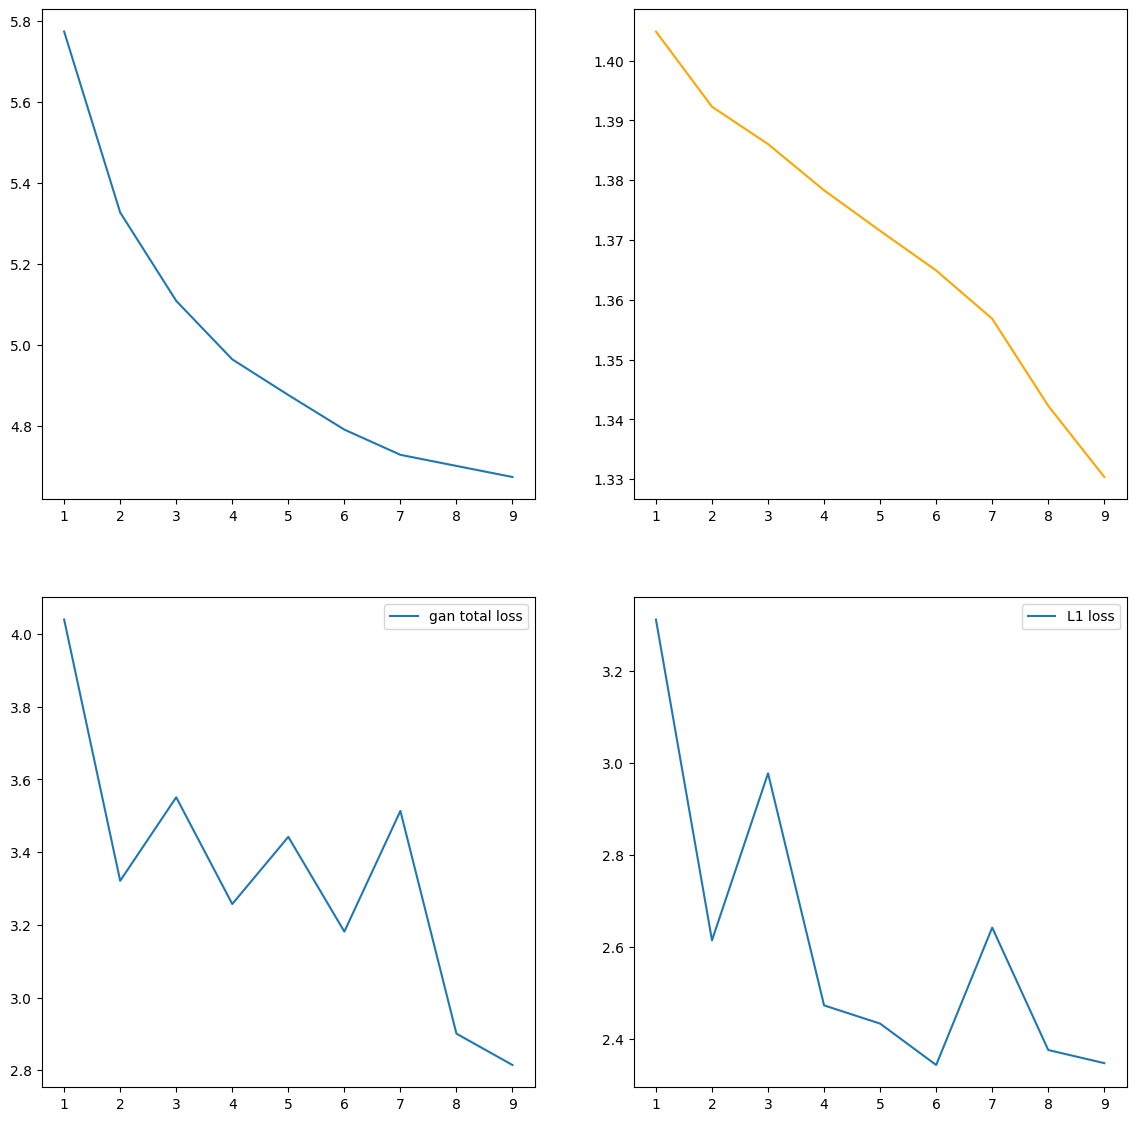

Seed :  308

Start of epoch 10


[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 15885903037279473911


step 0 gen_loss : 5.4808455 disc_loss : 0.89921397 Bright coef : 0.7131972867768339
step 1 gen_loss : 5.19919 disc_loss : 0.7915395 Bright coef : 0.8157795012213003
step 2 gen_loss : 2.914696 disc_loss : 1.647776 Bright coef : 0.7
step 3 gen_loss : 5.0734024 disc_loss : 0.9841763 Bright coef : 1.1262070571766818
step 4 gen_loss : 4.6522856 disc_loss : 0.99382114 Bright coef : 0.9268999725303759
step 5 gen_loss : 3.4887924 disc_loss : 1.0955384 Bright coef : 0.8877629911638336
step 6 gen_loss : 4.5128026 disc_loss : 1.387408 Bright coef : 0.9475771855674695
step 7 gen_loss : 5.6286297 disc_loss : 1.1846188 Bright coef : 0.7
step 8 gen_loss : 2.6469424 disc_loss : 1.130626 Bright coef : 0.7993753071989482
step 9 gen_loss : 4.7052608 disc_loss : 0.68188936 Bright coef : 0.7
step 10 gen_loss : 4.12178 disc_loss : 1.5480934 Bright coef : 1.0350738351352748
step 11 gen_loss : 4.566093 disc_loss : 1.5967857 Bright coef : 0.9012318820972645
step 12 gen_loss : 6.1242566 disc_loss : 0.89236844 B

step 104 gen_loss : 3.6987429 disc_loss : 1.4186076 Bright coef : 0.7799605017214363
step 105 gen_loss : 4.451309 disc_loss : 0.6303148 Bright coef : 0.9112752386199092
step 106 gen_loss : 5.5721655 disc_loss : 0.7088737 Bright coef : 1.0334342665225023
step 107 gen_loss : 4.2911344 disc_loss : 1.4143078 Bright coef : 0.7
step 108 gen_loss : 4.642031 disc_loss : 0.7070466 Bright coef : 0.990247284178592
step 109 gen_loss : 3.373296 disc_loss : 1.2639184 Bright coef : 0.8585421084439699
step 110 gen_loss : 1.7749119 disc_loss : 1.3431976 Bright coef : 0.7051637611458662
step 111 gen_loss : 3.9968505 disc_loss : 1.5426999 Bright coef : 0.9365874348077996
step 112 gen_loss : 4.031044 disc_loss : 1.2297939 Bright coef : 0.9667862521963162
step 113 gen_loss : 2.8822067 disc_loss : 1.3083701 Bright coef : 0.7441788673952886
step 114 gen_loss : 8.03539 disc_loss : 0.4406454 Bright coef : 0.9913333637013799
step 115 gen_loss : 4.533416 disc_loss : 1.0201181 Bright coef : 0.7
step 116 gen_loss 

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


step 161 gen_loss : 2.992414 disc_loss : 1.2920722 Bright coef : 0.7
step 162 gen_loss : 3.9661336 disc_loss : 1.6360898 Bright coef : 0.9566587345935682
step 163 gen_loss : 3.817112 disc_loss : 1.6500019 Bright coef : 0.7419506152461619
step 164 gen_loss : 3.8164656 disc_loss : 1.738244 Bright coef : 0.7
step 165 gen_loss : 2.661233 disc_loss : 1.343264 Bright coef : 0.7
step 166 gen_loss : 2.4784415 disc_loss : 1.400995 Bright coef : 0.7
step 167 gen_loss : 6.4169383 disc_loss : 0.5379927 Bright coef : 1.0511481448508366
step 168 gen_loss : 2.5894668 disc_loss : 1.405072 Bright coef : 0.7
step 169 gen_loss : 3.3349006 disc_loss : 1.5220339 Bright coef : 0.7
step 170 gen_loss : 3.046118 disc_loss : 0.9137808 Bright coef : 0.8306855766168466
step 171 gen_loss : 4.2467904 disc_loss : 1.1392425 Bright coef : 0.9752200547456212
step 172 gen_loss : 11.731436 disc_loss : 0.6254243 Bright coef : 1.0050831365424093
step 173 gen_loss : 3.416449 disc_loss : 1.1067859 Bright coef : 0.95754201822

step 264 gen_loss : 6.115226 disc_loss : 1.8339956 Bright coef : 0.7603216933105509
step 265 gen_loss : 5.1535645 disc_loss : 1.1125728 Bright coef : 0.9900465094593213
step 266 gen_loss : 4.9413395 disc_loss : 1.2434338 Bright coef : 0.9199907269584966
step 267 gen_loss : 3.595614 disc_loss : 1.2353982 Bright coef : 0.7
step 268 gen_loss : 3.9525552 disc_loss : 1.1359327 Bright coef : 0.8516960844178635
step 269 gen_loss : 2.4259603 disc_loss : 1.2921388 Bright coef : 1.1243456115089363
step 270 gen_loss : 3.8534732 disc_loss : 1.5014968 Bright coef : 0.9766348437280754
step 271 gen_loss : 4.2714944 disc_loss : 0.986516 Bright coef : 1.1846020795313987
step 272 gen_loss : 4.2672815 disc_loss : 1.1311765 Bright coef : 0.7505139644613589
step 273 gen_loss : 2.9778466 disc_loss : 1.1703656 Bright coef : 0.7
step 274 gen_loss : 2.4356196 disc_loss : 1.4384544 Bright coef : 0.9108783723064607
step 275 gen_loss : 7.03082 disc_loss : 1.1373034 Bright coef : 1.1836000822510426
step 276 gen_lo

step 367 gen_loss : 5.3258247 disc_loss : 1.1046814 Bright coef : 0.8061747308049789
step 368 gen_loss : 2.3329835 disc_loss : 1.037471 Bright coef : 0.7
step 369 gen_loss : 2.8322253 disc_loss : 0.91692287 Bright coef : 0.7
step 370 gen_loss : 6.0401883 disc_loss : 0.6232349 Bright coef : 0.7
step 371 gen_loss : 4.115128 disc_loss : 0.95509875 Bright coef : 1.0438632904249672
step 372 gen_loss : 3.8062906 disc_loss : 0.7080425 Bright coef : 0.9924749226735314
step 373 gen_loss : 5.828643 disc_loss : 0.7366989 Bright coef : 1.0858572844258727
step 374 gen_loss : 5.785221 disc_loss : 1.1555433 Bright coef : 0.7
step 375 gen_loss : 4.5942054 disc_loss : 0.74386364 Bright coef : 0.9174700469550578
step 376 gen_loss : 4.212367 disc_loss : 1.2383523 Bright coef : 0.7
step 377 gen_loss : 3.6279862 disc_loss : 0.96783143 Bright coef : 0.7
step 378 gen_loss : 3.3840914 disc_loss : 1.2345525 Bright coef : 0.7
step 379 gen_loss : 4.6155295 disc_loss : 1.1366378 Bright coef : 0.7
step 380 gen_los

KeyboardInterrupt: 

In [9]:
# Test Path
path_test = 'test/test_set'
# Save path
save_model = 'save_models/V3/Kmeans_64/'
save_loss = 'loss/V3/Kmeans_64/'
#load
#generator.load_weights(save_model+'gen_model_color_epoch_5.h5')
#discriminator.load_weights(save_model+'dis_model_color_epoch_5.h5')

EPOCHS_START=1
EPOCHS = 50
BATCH_SIZE=1
LR_G = LR_D = 1.5e-4
print("Learning Rate G : "+str(LR_G)+" Learning Rate D : "+str(LR_D))
#generator_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)   
#discriminator_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5) 
#
GLoss=[]
DLoss=[]
#
# Load dataset 
Dataset = tf.data.Dataset.load('./Dataset_wo_sky/V_Urban_Launcher/Dataset_VU')
#
if EPOCHS_START!=1:
    #load loss
    GLoss_Epochs = list(np.load(save_loss+'Gloss_mean_5.npy')[0:EPOCHS_START])
    DLoss_Epochs = list(np.load(save_loss+'Dloss_mean_5.npy')[0:EPOCHS_START])
    TLoss_Epochs = list(np.load(save_loss+'Tloss_mean_5.npy')[0:EPOCHS_START])
    TLoss_L1_Epochs = list(np.load(save_loss+'Tloss_L1_mean_5.npy')[0:EPOCHS_START])
else:
    GLoss_Epochs=[]
    DLoss_Epochs=[]
    TLoss_Epochs=[]
    TLoss_L1_Epochs=[]
#
for i in range(EPOCHS_START,EPOCHS+1):
    #
    SEED = random.randint(0,10000)
    print('Seed : ',SEED)
    # SHUFFLE AND BATCH
    Dataset_B = shuffle_and_batch(Dataset, 50, SEED)
    #
    print("\nStart of epoch %d" % (i,))
    #
    # train model
    (D,G,discriminator, generator)=train(discriminator, generator, Dataset_B, batch=BATCH_SIZE)
    GLoss.append(np.mean(G))
    DLoss.append(np.mean(D))
        
    GLoss_Epochs.append(np.mean(GLoss))
    DLoss_Epochs.append(np.mean(DLoss))
            
    discriminator.save_weights(save_model+'dis_model_color_epoch_'+str(i)+'.h5')
    generator.save_weights(save_model+'gen_model_color_epoch_'+str(i)+'.h5')
        
    # test loss
    AVG, L1 = test_loss_avg(generator,path_test)
    TLoss_Epochs.append(AVG)
    TLoss_L1_Epochs.append(L1)

    # Save loss
    np.save(save_loss+'Dloss_mean_'+str(i)+'.npy',DLoss_Epochs)
    np.save(save_loss+'Gloss_mean_'+str(i)+'.npy',GLoss_Epochs)
    np.save(save_loss+'Tloss_mean_'+str(i)+'.npy',TLoss_Epochs)
    np.save(save_loss+'Tloss_L1_mean_'+str(i)+'.npy',TLoss_L1_Epochs)

    X_EPOCHS = np.arange(1,i+1, 1)
    
    print('X : ',X_EPOCHS)
    print('G : ',GLoss_Epochs)
    print('D : ',DLoss_Epochs)
    print('T_avg : ',TLoss_Epochs)
    print('T_L1 : ',TLoss_L1_Epochs)

    plt.figure(figsize=(14,14))
    plt.subplot(2, 2, 1)
    plt.plot(X_EPOCHS, GLoss_Epochs)
    plt.subplot(2, 2, 2)
    plt.plot(X_EPOCHS, DLoss_Epochs,'orange')
    plt.subplot(2, 2, 3)
    plt.plot(X_EPOCHS, np.array(TLoss_Epochs), label='gan total loss')
    plt.legend()
    plt.subplot(2, 2, 4)
    plt.plot(X_EPOCHS, LAMBDA*np.array(TLoss_L1_Epochs), label='L1 loss')
    plt.legend()
    #
    if (i%5 == 0):
        plt.savefig(save_loss+'Loss_'+str(i)+'.png')
        print('Saved')   
    plt.show()             

# save models
print("gan_model")

In [14]:
# try on a test image
import cv2
from tensorflow import keras
import numpy as np

save_models = 'save_models/V3/Kmeans_64/'
val_path = 'test/val_set/V3/Kmeans_64/'
image_shape=(512,512,3)

num = 8

# define the models
generator = define_generator(image_shape)
#load initial weights
generator.load_weights(save_models+'gen_model_color_epoch_'+str(num)+'.h5') #4,5,13,25

if ('gen_'+str(num)) not in os.listdir(val_path):
    os.mkdir(val_path+'gen_'+str(num))

doss_image = val_path+'org'
doss_gen = val_path+'gen_'+str(num)  #V17/gen_50'

IMAGE=os.listdir(doss_image)
IMAGE.sort()

for file in IMAGE:
    old = os.path.join(doss_image,file)
    new = os.path.join(doss_gen,file+'_TGAN_'+str(num)+'.png') 
    #new = os.path.join(doss_gen,file) 
    X1=[]
    # now read the input image files (difference from the code it is derived from that preloads all images)
    pixels = Image.open(old).convert("RGB")
    L_src, ab_src=rgb_to_lab(pixels)
    X1.append(L_src)
    X1=np.array(X1)
    L_src = X1[..., np.newaxis]
    ab_src=ab_src[np.newaxis, ...]
    #
    ab_fake = generator(tf.keras.layers.concatenate([L_src, ab_src]), training=False)
    print(ab_fake)
    
    img=tf.keras.layers.concatenate([L_src, ab_fake])
    img=lab_to_rgb(img)
    image_reco=Image.fromarray(img[0])
    image_reco = image_reco.save(new)

(6, 2, 2)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 encoder_block_0 (Conv2D)    (None, 512, 512, 32)         896       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_54 (Ba  (None, 512, 512, 32)         128       ['encoder_block_0[0][0]']     
 tchNormalization)                                                                                
                                                                                                  
 leaky_re_lu_30 (LeakyReLU)  (None, 512, 512, 32)         0         ['batch_normal

 activation_39 (Activation)  (None, 128, 128, 256)        0         ['concatenate_38693[0][0]']   
                                                                                                  
 decoder_block_1 (Conv2DTra  (None, 256, 256, 64)         147520    ['activation_39[0][0]']       
 nspose)                                                                                          
                                                                                                  
 batch_normalization_62 (Ba  (None, 256, 256, 64)         256       ['decoder_block_1[0][0]']     
 tchNormalization)                                                                                
                                                                                                  
 concatenate_38694 (Concate  (None, 256, 256, 128)        0         ['batch_normalization_62[0][0]
 nate)                                                              ',                            
          

tf.Tensor(
[[[[-0.01029248  0.04825437]
   [ 0.02484477  0.07889745]
   [ 0.0144007   0.06364218]
   ...
   [-0.02634238 -0.11773194]
   [-0.05214151 -0.10428181]
   [-0.02756091 -0.03946308]]

  [[ 0.00111742  0.06866925]
   [ 0.00303938  0.08418106]
   [ 0.00325253  0.10257252]
   ...
   [-0.03068708 -0.14002843]
   [-0.03331439 -0.17460386]
   [-0.045538   -0.10699823]]

  [[ 0.01242777  0.08094244]
   [ 0.00338185  0.03598751]
   [-0.01035695  0.06860512]
   ...
   [-0.02186883 -0.1783662 ]
   [-0.05220468 -0.17820108]
   [-0.03665602 -0.10564219]]

  ...

  [[-0.13172036  0.16759165]
   [-0.13645196  0.21421811]
   [-0.15074176  0.21421635]
   ...
   [-0.07951955  0.00360063]
   [-0.07466256  0.03870538]
   [-0.05934744  0.06477991]]

  [[-0.10123263  0.19100125]
   [-0.1144719   0.19473736]
   [-0.11735295  0.21246052]
   ...
   [-0.06308407  0.08002675]
   [-0.07483068  0.08388846]
   [-0.02324908  0.03842761]]

  [[-0.12331291  0.1537184 ]
   [-0.1226451   0.12175248]
   [-0.11

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 13 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-3.70680913e-02 -2.27649622e-02]
   [-6.69506751e-03 -2.90774554e-02]
   [-2.67556030e-02 -1.32958032e-02]
   ...
   [-3.64208757e-03  1.78155657e-02]
   [-1.66832209e-02  3.04307928e-03]
   [-9.83056612e-03  4.00937349e-03]]

  [[-1.14352712e-02 -1.24522656e-01]
   [-3.83357406e-02 -1.36587635e-01]
   [-3.06172203e-02 -1.39844239e-01]
   ...
   [ 6.22923905e-03  6.80234050e-03]
   [ 1.07728485e-02 -1.94945242e-02]
   [ 4.68802266e-03 -7.64655974e-03]]

  [[ 1.77234095e-02 -1.03861861e-01]
   [ 1.30879227e-04 -9.06966329e-02]
   [ 2.54006702e-02 -1.02328166e-01]
   ...
   [ 1.70842465e-02  3.33039686e-02]
   [ 1.26986811e-02 -3.28853703e-03]
   [ 1.28848990e-03  1.27085322e-03]]

  ...

  [[ 1.17796324e-02 -3.19063812e-02]
   [-2.57255919e-02 -3.22782174e-02]
   [ 1.47094084e-02 -2.53965780e-02]
   ...
   [-3.81913036e-02 -1.31215081e-01]
   [-5.46737313e-02 -1.43697232e-01]
   [-3.21435593e-02 -1.27597436e-01]]

  [[-1.09897833e-02 -3.77702788e-02]
   [-1.01744859e-02 -

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 2 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.01889933 -0.04419885]
   [ 0.00482538 -0.07334229]
   [-0.01277531 -0.07376393]
   ...
   [-0.00745054 -0.07579459]
   [-0.03590416 -0.0752467 ]
   [-0.00252301 -0.02777342]]

  [[-0.00778307 -0.10136393]
   [-0.02305004 -0.10596723]
   [-0.02419012 -0.12493091]
   ...
   [-0.0077052  -0.08135191]
   [-0.0118242  -0.12246864]
   [-0.02325474 -0.06114556]]

  [[ 0.00641434 -0.12951647]
   [-0.02889446 -0.13640855]
   [-0.02464777 -0.16159813]
   ...
   [-0.025819   -0.11467973]
   [-0.03561034 -0.14586687]
   [-0.03295174 -0.08929657]]

  ...

  [[-0.07632042  0.1323783 ]
   [-0.09017619  0.15387887]
   [-0.062404    0.12462653]
   ...
   [-0.02420508 -0.03877375]
   [ 0.03558609 -0.01214334]
   [ 0.04809762  0.00121912]]

  [[-0.05639915  0.12492238]
   [-0.06040149  0.13940388]
   [-0.0464176   0.12870009]
   ...
   [ 0.04714667  0.00904737]
   [ 0.05061142 -0.01684178]
   [ 0.09565402  0.02919626]]

  [[-0.07389133  0.07989929]
   [-0.08084596  0.07202414]
   [-0.07

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 10 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.02645469 -0.01017442]
   [-0.00421255 -0.02571089]
   [-0.02946587 -0.00539091]
   ...
   [-0.01174097 -0.04559415]
   [-0.05639564 -0.05436202]
   [-0.01103254 -0.02198843]]

  [[-0.01078078 -0.10434749]
   [-0.03753003 -0.09259923]
   [-0.04337164 -0.11725055]
   ...
   [-0.04068643 -0.09087403]
   [-0.04556003 -0.19258939]
   [-0.05171815 -0.10070185]]

  [[ 0.01446791 -0.07589559]
   [-0.0350784  -0.08352819]
   [-0.01384167 -0.09112389]
   ...
   [-0.03265278 -0.07608984]
   [-0.04313761 -0.13405353]
   [-0.01976793 -0.09129036]]

  ...

  [[-0.00965929 -0.06642851]
   [-0.0307397  -0.03119472]
   [-0.01855371 -0.0273858 ]
   ...
   [-0.00387118 -0.00659772]
   [-0.01878216 -0.02441819]
   [-0.01378438 -0.02480199]]

  [[-0.02704532 -0.0541511 ]
   [-0.02964758 -0.03682701]
   [-0.01876385 -0.04757934]
   ...
   [-0.00780593 -0.00044664]
   [-0.02573462 -0.05065891]
   [-0.01742147 -0.00680493]]

  [[ 0.00107354 -0.04292084]
   [-0.01668295 -0.04512376]
   [-0.02

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 6 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.01257153 -0.09460355]
   [-0.01948183 -0.10036992]
   [-0.03686027 -0.11487085]
   ...
   [-0.01640576 -0.1215158 ]
   [-0.04192504 -0.10097242]
   [-0.02342097 -0.03806451]]

  [[-0.01214788 -0.10856005]
   [-0.0346749  -0.14899972]
   [-0.03160239 -0.14304851]
   ...
   [-0.02596126 -0.1131791 ]
   [-0.01725389 -0.1522412 ]
   [-0.02934517 -0.09977958]]

  [[-0.01227253 -0.15545034]
   [-0.0491214  -0.1591205 ]
   [-0.03105294 -0.1829413 ]
   ...
   [-0.02807386 -0.14838552]
   [-0.03350731 -0.17226057]
   [-0.02374982 -0.11476265]]

  ...

  [[ 0.04021951  0.03449123]
   [ 0.05551174  0.04596918]
   [ 0.06313176  0.03840721]
   ...
   [ 0.03619445  0.07764283]
   [ 0.01695754  0.09534886]
   [ 0.03572099  0.10839792]]

  [[ 0.04297795  0.03128192]
   [ 0.05055973  0.05531312]
   [ 0.06825116  0.05145522]
   ...
   [ 0.03022214  0.06481311]
   [ 0.03414606  0.06072853]
   [ 0.03446423  0.08920602]]

  [[ 0.03188142 -0.00905544]
   [ 0.04777949 -0.01551253]
   [ 0.04

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.01246459 -0.0657068 ]
   [-0.01371761 -0.07565692]
   [-0.02748624 -0.07724012]
   ...
   [-0.01084753 -0.08418852]
   [-0.04123532 -0.06601594]
   [-0.01178479 -0.02115662]]

  [[-0.00264726 -0.07343742]
   [-0.01954437 -0.09033523]
   [-0.02906526 -0.0824837 ]
   ...
   [-0.01559544 -0.07448752]
   [-0.0150486  -0.10986061]
   [-0.02263741 -0.06313522]]

  [[-0.0170131  -0.10875674]
   [-0.03107943 -0.11836916]
   [-0.02344368 -0.13248612]
   ...
   [-0.02648176 -0.12149555]
   [-0.03747669 -0.1300275 ]
   [-0.02363377 -0.06705421]]

  ...

  [[-0.10253661  0.21264978]
   [-0.09778963  0.26482415]
   [-0.06849482  0.24746817]
   ...
   [-0.00063772 -0.04979167]
   [ 0.00377283 -0.06454415]
   [-0.01212302 -0.05337199]]

  [[-0.05784366  0.24151045]
   [-0.06770211  0.27258104]
   [-0.03246225  0.30769622]
   ...
   [ 0.01466595 -0.04681791]
   [ 0.01420659 -0.1032232 ]
   [ 0.02571901 -0.03693167]]

  [[-0.09202916  0.1554186 ]
   [-0.08516034  0.21023671]
   [-0.07

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.0075345  -0.02081959]
   [ 0.0084979  -0.02947328]
   [-0.01674723 -0.01736869]
   ...
   [-0.01165154 -0.06225193]
   [-0.03790749 -0.05874719]
   [-0.0102633  -0.02518127]]

  [[ 0.00644017 -0.07828595]
   [-0.02829736 -0.07589283]
   [-0.02962861 -0.07386754]
   ...
   [-0.03037564 -0.07993043]
   [-0.02858722 -0.15017258]
   [-0.03139362 -0.09304985]]

  [[ 0.01824069 -0.06909061]
   [-0.01952005 -0.0859078 ]
   [-0.00984518 -0.08779694]
   ...
   [-0.02521002 -0.09200385]
   [-0.03077511 -0.12577115]
   [-0.01872406 -0.08353353]]

  ...

  [[-0.00763227 -0.02207933]
   [-0.00626724 -0.00659571]
   [-0.00666255 -0.00933845]
   ...
   [-0.05414714  0.07534584]
   [-0.05298062  0.05435342]
   [-0.07767677  0.05811173]]

  [[-0.01919007 -0.01489351]
   [-0.03155067 -0.01899154]
   [-0.00873227 -0.02432935]
   ...
   [-0.0369231   0.10758875]
   [-0.0467925   0.04246966]
   [-0.06104816  0.04420898]]

  [[-0.01127565 -0.0150015 ]
   [-0.00863208 -0.03395087]
   [-0.01

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 3 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[ 0.01774825  0.00213612]
   [ 0.01072865  0.0508986 ]
   [ 0.00739777  0.0066122 ]
   ...
   [-0.00750474 -0.07792928]
   [-0.03782932 -0.07344873]
   [-0.00536757 -0.02729622]]

  [[ 0.04302143  0.02332545]
   [ 0.03987387  0.01980494]
   [ 0.03720471  0.00169664]
   ...
   [-0.01765972 -0.10987936]
   [-0.01808852 -0.1564583 ]
   [-0.02827718 -0.07965366]]

  [[ 0.04153337  0.01714351]
   [ 0.02397066  0.01567919]
   [ 0.01871607 -0.01415387]
   ...
   [-0.02206156 -0.12847163]
   [-0.0386364  -0.16657993]
   [-0.02567462 -0.09707887]]

  ...

  [[ 0.20987128  0.23609506]
   [ 0.24615501  0.23105407]
   [ 0.27823058  0.23922026]
   ...
   [ 0.00164142 -0.04439453]
   [ 0.00057316  0.00090539]
   [ 0.02598886  0.00456696]]

  [[ 0.21908365  0.21799059]
   [ 0.25310224  0.2842901 ]
   [ 0.33098423  0.32096285]
   ...
   [ 0.01997396 -0.03619288]
   [ 0.03146039 -0.03486641]
   [ 0.03372622 -0.01747718]]

  [[ 0.19233091  0.15156847]
   [ 0.23080257  0.16455229]
   [ 0.25

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 172 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.00244778 -0.03872656]
   [ 0.01086004 -0.03050752]
   [-0.00970641 -0.03325593]
   ...
   [ 0.03700003  0.10501217]
   [ 0.04271045  0.064262  ]
   [ 0.03674499  0.03894857]]

  [[ 0.00205193 -0.05053151]
   [-0.00528735 -0.02659814]
   [-0.00595114 -0.05047877]
   ...
   [ 0.07587083  0.14895381]
   [ 0.06920005  0.08592492]
   [ 0.04351684  0.08947209]]

  [[ 0.00226462 -0.02945097]
   [-0.00825451  0.00435612]
   [ 0.00317901 -0.04310291]
   ...
   [ 0.09305324  0.13895059]
   [ 0.08477982  0.07814235]
   [ 0.06469253  0.08653578]]

  ...

  [[ 0.02599164  0.07518721]
   [ 0.04751022  0.1018986 ]
   [ 0.04470936  0.10351244]
   ...
   [ 0.08268244  0.1252686 ]
   [ 0.06787013  0.11291097]
   [ 0.04045353  0.10825133]]

  [[ 0.00689662  0.02262747]
   [ 0.01257891  0.04482168]
   [ 0.0318439   0.02734018]
   ...
   [ 0.09457155  0.10931282]
   [ 0.06723467  0.08097082]
   [ 0.06223231  0.07751758]]

  [[ 0.00648123  0.01616106]
   [-0.00135361  0.01819982]
   [-0.00

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 5 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.01921209 -0.10754125]
   [-0.02972107 -0.10915985]
   [-0.04084235 -0.12338667]
   ...
   [-0.02404313 -0.13012655]
   [-0.04732709 -0.11141175]
   [-0.0217552  -0.04356454]]

  [[-0.02039264 -0.12250456]
   [-0.0395369  -0.16075684]
   [-0.02783921 -0.16020003]
   ...
   [-0.02171636 -0.14538954]
   [-0.00934152 -0.1693146 ]
   [-0.03205387 -0.11287463]]

  [[-0.0293828  -0.16768123]
   [-0.05459011 -0.17073354]
   [-0.02975542 -0.19977406]
   ...
   [-0.02925759 -0.17345765]
   [-0.03211863 -0.18864371]
   [-0.02832486 -0.12401047]]

  ...

  [[ 0.0109913   0.03841651]
   [ 0.0462877   0.06775698]
   [ 0.07449613  0.07534584]
   ...
   [ 0.16306095  0.31270328]
   [ 0.13408257  0.3040136 ]
   [ 0.15813167  0.318851  ]]

  [[ 0.01899358  0.01692564]
   [ 0.02055115  0.05057772]
   [ 0.06350335  0.09189176]
   ...
   [ 0.16952325  0.30684188]
   [ 0.17465182  0.31195846]
   [ 0.17617352  0.2986532 ]]

  [[ 0.00956495 -0.0121268 ]
   [-0.00308885 -0.02399262]
   [ 0.02

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 12 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.03596099 -0.04558473]
   [-0.01379368 -0.05794524]
   [-0.02389388 -0.06472812]
   ...
   [-0.00616226 -0.06787995]
   [-0.04474919 -0.06739648]
   [-0.00388668 -0.01603222]]

  [[-0.01005777 -0.10558215]
   [-0.04109886 -0.13186795]
   [-0.04069441 -0.12341919]
   ...
   [-0.02636308 -0.10119024]
   [-0.02948837 -0.14213921]
   [-0.03854088 -0.06247345]]

  [[-0.01214007 -0.13401873]
   [-0.05387666 -0.13577825]
   [-0.03306663 -0.16139235]
   ...
   [-0.04375127 -0.1288226 ]
   [-0.05319172 -0.16354735]
   [-0.04549298 -0.08331993]]

  ...

  [[-0.06007222  0.11729819]
   [-0.07735392  0.10062238]
   [-0.07003368  0.10015208]
   ...
   [-0.02801132 -0.01189644]
   [-0.02727601  0.00804967]
   [-0.01434919  0.01241513]]

  [[-0.04935509  0.10883979]
   [-0.04603123  0.12154841]
   [-0.03465188  0.10771504]
   ...
   [-0.02144578 -0.02498302]
   [-0.01658345 -0.01125063]
   [-0.0089708   0.00596434]]

  [[-0.0502818   0.07162219]
   [-0.06953321  0.03604295]
   [-0.06

/tmp/ipykernel_10476/1133403014.py:9: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 7 negative Z values that have been clipped to zero
  img = lab2rgb(img_lab).astype("float32")


tf.Tensor(
[[[[-0.01334196  0.00907749]
   [ 0.02720028  0.02970996]
   [ 0.00216316  0.02100616]
   ...
   [-0.02081515 -0.09935828]
   [-0.04828653 -0.08449392]
   [-0.01035904 -0.03303459]]

  [[ 0.00871737 -0.01025122]
   [ 0.00466697  0.02566556]
   [-0.00756361  0.02732182]
   ...
   [-0.03077262 -0.11215954]
   [-0.02334333 -0.16053768]
   [-0.03876368 -0.08654968]]

  [[ 0.02310979 -0.00492844]
   [-0.00942507 -0.02276167]
   [-0.00281193 -0.00592199]
   ...
   [-0.04070809 -0.14270288]
   [-0.03607866 -0.16738512]
   [-0.02398071 -0.10734511]]

  ...

  [[-0.02593229 -0.06172019]
   [-0.02057108 -0.05877934]
   [-0.01438809 -0.06788535]
   ...
   [ 0.06924688  0.1155435 ]
   [ 0.05061564  0.11784181]
   [ 0.06266131  0.1152031 ]]

  [[-0.01271438 -0.06314232]
   [-0.01306774 -0.06953835]
   [-0.00630495 -0.07125204]
   ...
   [ 0.07790243  0.12530252]
   [ 0.08199131  0.10806167]
   [ 0.08658288  0.1151775 ]]

  [[ 0.01404937 -0.05273365]
   [-0.01292127 -0.06590256]
   [ 0.00

tf.Tensor(
[[[[-1.8925143e-02 -3.8963627e-02]
   [ 3.5784673e-05 -5.2568596e-02]
   [-1.6526904e-02 -4.5894105e-02]
   ...
   [-1.8629320e-02 -7.1528792e-02]
   [-3.9440986e-02 -4.7554594e-02]
   [-6.5290565e-03 -1.7726492e-02]]

  [[ 7.8249052e-03 -7.6607749e-02]
   [-1.2745711e-02 -8.8126734e-02]
   [-1.5995054e-02 -7.9030767e-02]
   ...
   [-1.5407330e-02 -5.9929714e-02]
   [-6.0777748e-03 -1.1353208e-01]
   [-2.0599810e-02 -5.3636611e-02]]

  [[ 1.1932490e-02 -9.4323523e-02]
   [-1.5121434e-02 -8.4199011e-02]
   [ 8.8876998e-03 -1.0393572e-01]
   ...
   [-1.0205279e-02 -8.6110741e-02]
   [-8.1509696e-03 -1.0394995e-01]
   [-1.5505876e-02 -7.2430387e-02]]

  ...

  [[ 1.3731380e-02  4.3561455e-02]
   [ 2.8533155e-02  3.6759913e-02]
   [ 8.6940639e-03  5.4301981e-02]
   ...
   [ 3.1184888e-02  1.5891421e-01]
   [-4.6119266e-03  1.6345587e-01]
   [ 2.2267260e-02  1.6216052e-01]]

  [[ 1.0281222e-02  6.3296117e-02]
   [ 1.8894147e-02  5.3642664e-02]
   [ 1.9657681e-02  6.0878463e-02]
 

**FID METRICS**

In [42]:
from scipy.linalg import sqrtm

doss_gen = 'test/val_set/V3/GENERATED/'
Liste = os.listdir(doss_gen)
Liste.sort()

doss_org = 'test/val_set/V3/org/'
ORG = os.listdir(doss_org)
ORG.sort()

FID=[]

# load inception v3 model
#model = InceptionV3()
model = tf.keras.applications.inception_v3.InceptionV3()
# prepare the inception v3 model
model = tf.keras.applications.inception_v3.InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def scale_images(images, new_shape):
    images_list=[]
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = np.resize(image, new_shape)  # ,0
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

def load_images(path,liste):
    img_list = []
    for im_path in liste:
        #im = cv2.imread(path+im_path)
        im_rgb = np.asarray(Image.open(os.path.join(path,im_path)).convert("RGB"))
        print(im_path)
        print(im_rgb.shape)
        #im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_rgb = im_rgb.astype('float32')
        img_list.append(im_rgb)
    return(img_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

for doss in Liste:
    gen_file= os.listdir(doss_gen+doss)
    gen_file.sort()
    
    org_imgs = load_images(doss_org,ORG)
    gen_imgs = load_images(doss_gen+doss,gen_file)
    # resize images
    images_org = scale_images(org_imgs, (299,299,3))
    images_gen = scale_images(gen_imgs, (299,299,3))

    # fid between images1 and images2
    fid = calculate_fid(model, images_org, images_gen)
    FID.append(fid)
    print('FID : %.3f' % fid)

# fid between images1 and images1
#fid = calculate_fid(model, images_org, images_org)
#print('FID (same): %.3f' % fid)


image_00000001-3.png
(512, 512, 3)
image_00000001.png
(512, 512, 3)
image_00000002-3.png
(512, 512, 3)
image_00000002_1.png
(512, 512, 3)
image_00000003_1.png
(512, 512, 3)
image_00000003_2.png
(512, 512, 3)
image_00000004_4.png
(512, 512, 3)
image_00000005-3.png
(512, 512, 3)
image_00000006-3.png
(512, 512, 3)
image_00000006_4.png
(512, 512, 3)
image_00000008-3.png
(512, 512, 3)
image_00000008.png
(512, 512, 3)
image_00000009-3.png
(512, 512, 3)
image_00000009_1.png
(512, 512, 3)
image_00000010_2.png
(512, 512, 3)
image_00000010_4.png
(512, 512, 3)
image_00000011_4.png
(512, 512, 3)
image_00000012.png
(512, 512, 3)
image_00000013.png
(512, 512, 3)
image_00000013_1.png
(512, 512, 3)
image_00000014_1.png
(512, 512, 3)
image_00000014_2.png
(512, 512, 3)
image_00000015_4.png
(512, 512, 3)
image_00000016.png
(512, 512, 3)
image_00000017-3.png
(512, 512, 3)
image_00000017.png
(512, 512, 3)
image_00000018-3.png
(512, 512, 3)
image_00000018_1.png
(512, 512, 3)
image_00000019_1.png
(512, 512, 

2/2 [==============================] - 0s 143ms/step
FID : 2201.735
image_00000001-3.png
(512, 512, 3)
image_00000001.png
(512, 512, 3)
image_00000002-3.png
(512, 512, 3)
image_00000002_1.png
(512, 512, 3)
image_00000003_1.png
(512, 512, 3)
image_00000003_2.png
(512, 512, 3)
image_00000004_4.png
(512, 512, 3)
image_00000005-3.png
(512, 512, 3)
image_00000006-3.png
(512, 512, 3)
image_00000006_4.png
(512, 512, 3)
image_00000008-3.png
(512, 512, 3)
image_00000008.png
(512, 512, 3)
image_00000009-3.png
(512, 512, 3)
image_00000009_1.png
(512, 512, 3)
image_00000010_2.png
(512, 512, 3)
image_00000010_4.png
(512, 512, 3)
image_00000011_4.png
(512, 512, 3)
image_00000012.png
(512, 512, 3)
image_00000013.png
(512, 512, 3)
image_00000013_1.png
(512, 512, 3)
image_00000014_1.png
(512, 512, 3)
image_00000014_2.png
(512, 512, 3)
image_00000015_4.png
(512, 512, 3)
image_00000016.png
(512, 512, 3)
image_00000017-3.png
(512, 512, 3)
image_00000017.png
(512, 512, 3)
image_00000018-3.png
(512, 512, 3)

image_00000031.png
(512, 512, 3)
image_00000096-3.png
(512, 512, 3)
image_00000099-3.png
(512, 512, 3)
image_00000099_1.png
(512, 512, 3)
image_00000138-3.png
(512, 512, 3)
im_001.jpg
(512, 512, 3)
im_002.jpg
(512, 512, 3)
im_003.jpg
(512, 512, 3)
im_004.jpg
(512, 512, 3)
im_005.jpg
(512, 512, 3)
im_006.jpg
(512, 512, 3)
im_007.jpg
(512, 512, 3)
im_008.jpg
(512, 512, 3)
im_009.jpg
(512, 512, 3)
im_010.jpg
(512, 512, 3)
im_011.jpg
(512, 512, 3)
im_012.jpg
(512, 512, 3)
im_013.jpg
(512, 512, 3)
im_014.jpg
(512, 512, 3)
im_015.jpg
(512, 512, 3)
im_016.jpg
(512, 512, 3)
im_017.jpg
(512, 512, 3)
im_018.jpg
(512, 512, 3)
im_019.jpg
(512, 512, 3)
im_020.jpg
(512, 512, 3)
im_021.jpg
(512, 512, 3)
im_022.jpg
(512, 512, 3)
im_023.jpg
(512, 512, 3)
im_024.jpg
(512, 512, 3)
im_025.jpg
(512, 512, 3)
im_026.jpg
(512, 512, 3)
im_027.jpg
(512, 512, 3)
im_028.jpg
(512, 512, 3)
im_029.jpg
(512, 512, 3)
im_030.jpg
(512, 512, 3)
im_031.jpg
(512, 512, 3)
im_032.jpg
(512, 512, 3)
im_033.jpg
(512, 512, 3)
im

image_00000017.png
(512, 512, 3)
image_00000018-3.png
(512, 512, 3)
image_00000018_1.png
(512, 512, 3)
image_00000019_1.png
(512, 512, 3)
image_00000019_2.png
(512, 512, 3)
image_00000020_2.png
(512, 512, 3)
image_00000020_4.png
(512, 512, 3)
image_00000022-3.png
(512, 512, 3)
image_00000022.png
(512, 512, 3)
image_00000023-3.png
(512, 512, 3)
image_00000023_2.png
(512, 512, 3)
image_00000024_2.png
(512, 512, 3)
image_00000024_4.png
(512, 512, 3)
image_00000026-3.png
(512, 512, 3)
image_00000026_1.png
(512, 512, 3)
image_00000027_1.png
(512, 512, 3)
image_00000027_2.png
(512, 512, 3)
image_00000028_2.png
(512, 512, 3)
image_00000028_4.png
(512, 512, 3)
image_00000029_4.png
(512, 512, 3)
image_00000030.png
(512, 512, 3)
image_00000031-3.png
(512, 512, 3)
image_00000031.png
(512, 512, 3)
image_00000096-3.png
(512, 512, 3)
image_00000099-3.png
(512, 512, 3)
image_00000099_1.png
(512, 512, 3)
image_00000138-3.png
(512, 512, 3)
im_001.jpg
(512, 512, 3)
im_002.jpg
(512, 512, 3)
im_003.jpg
(5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


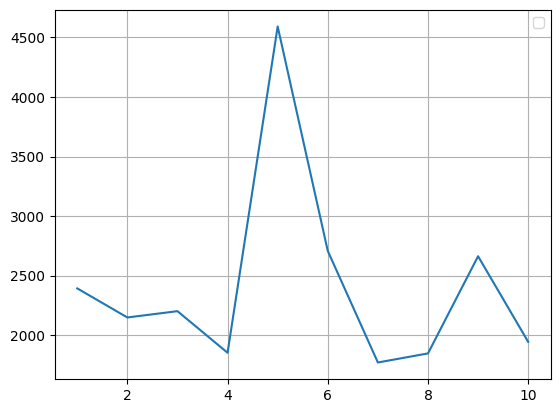

<Figure size 640x480 with 0 Axes>

In [43]:
X_GEN = np.arange(1,11)

plt.plot(X_GEN, FID)
plt.grid()
plt.legend()
plt.show()
plt.savefig(save_loss+'FID.png')

**Source**

https://github.com/soumith/ganhacks/issues/14
https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/

I think the discriminator got too strong relative to the generator. Beyond this point, the generator finds it almost impossible to fool the discriminator, hence the increase in it's loss. I'm facing a similar problem.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

Probably, the problem is that the discriminator overfit. One of the reasons leading to this is following thing:
discriminator may "notice" that images from true distribution is a matrix of numbers of the form n/255. So, adding gaussian noise to the input images may help to avoid the problem.
It helps in my case.

https://imatge.upc.edu/web/sites/default/files/pub/xTarres21.pdf

Dropout :
https://saturncloud.io/blog/how-to-properly-use-dropout-in-tensorflow-a-guide-for-data-scientists/

Filters :
https://datascience.stackexchange.com/questions/55545/in-cnn-why-do-we-increase-the-number-of-filters-in-deeper-convolution-layers-fo

Loss study :
https://arxiv.org/pdf/2204.02980.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/302.pdf

https://arxiv.org/pdf/1703.10593.pdf

https://arxiv.org/pdf/1603.08511.pdf



Training indicating whether the layer should behave in training mode or in inference mode.

    training=True: The layer will normalize its inputs using the mean and variance of the current batch of inputs.

    training=False: The layer will normalize its inputs using the mean and variance of its moving statistics, learned during training.

Usually in inference mode training=False, but in some networks such as pix2pix_cGAN‍‍‍‍‍‍ At both times of inference and training, training=True.

Seed counter tf : https://saturncloud.io/blog/tensorflow-different-results-with-the-same-random-seed/


In [ ]:
# Save optimizer weights
#symbolic_weights = getattr(discriminator.optimizer, 'weights')
#weight_values = K.batch_get_value(symbolic_weights)  # or symbolic_weights.numpy()
# Then store .npy
#
# Load optimizer weights
#weight_values = np.load(...)
#model.optimizer.set_weights(weight_values)